# Load Review

혹시 다시 이 코드를 써야하면.. LSTM이나 GRU 쪽 기반으로 돌리..기. 아니면 Train TEST로는 모델성능 평가만, 다음 WHOLE 데이터를 모델로 돌려서 감성 점수 겟-하기.

In [1]:
# for google 
# from google.colab import drive
# drive.mount('/gdrive')


In [4]:
import pickle
import time

import re
import os
import json
# !pip install pandas
import pandas as pd
import numpy as np
# !pip install bs4
from bs4 import BeautifulSoup
# !pip install nltk
from nltk.corpus import stopwords
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

import nltk
# nltk.download('all')
from nltk.corpus import wordnet as wn

## (데이터 넘기기용)Load whole data reviews

In [2]:
path = '/gdrive/MyDrive/movie_predict/DF/'+'all_reviews'
with open(path,'rb') as fr:
  review = pickle.load(fr)

FileNotFoundError: [Errno 2] No such file or directory: '/gdrive/MyDrive/movie_predict/DF/all_reviews'

In [ ]:
review['contents'].loc[0]

"Next Friday is actually pretty funny even though it lacks the film's first scene stealer Chris Tucker. Ice Cube makes a funny script with the help of new scene stealer Mike Epps who plays his cousin Day-Day. All in all if you just want a good time check this one out."

In [ ]:
# contents가 nan 이면 제거하는 코드..써야함
review.dropna(axis = 0,inplace = True)
review.reset_index(drop = True, inplace = True)
print(review.shape)
review.head()


(178076, 13)


,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,3_weeks_later,4_weeks_later,in_n_weeks,Movie_code,sentiment
0,Actually quite funny without Chris Tucker\n,2002-03-16,Next Friday is actually pretty funny even thou...,1.0,['17 out of 25'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1
1,Some good belly laughs\n,2000-04-11,It is not easy to sit through the whole movie ...,0.7,['4 out of 5'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1
2,I loved that movie\n,2000-07-25,Next Friday is a movie i enjoyed to see all 4 ...,1.0,['5 out of 7'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1
3,Worst of the trilogy but still pretty funny a...,2007-06-13,"Rated R for Language,Drug Use and Sexual Conte...",0.8,['8 out of 13'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1
4,will there be another next time???\n,2001-03-02,"i hope so. friday part one, might been more fu...",0.8,['5 out of 10'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1


In [ ]:
# 전처리 내용 담음.
review.reset_index(inplace = True)
review['id'] = review['index']
review

,index,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,3_weeks_later,4_weeks_later,in_n_weeks,Movie_code,sentiment,id
0,0,Actually quite funny without Chris Tucker\n,2002-03-16,Next Friday is actually pretty funny even thou...,1.0,['17 out of 25'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,0
1,1,Some good belly laughs\n,2000-04-11,It is not easy to sit through the whole movie ...,0.7,['4 out of 5'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,1
2,2,I loved that movie\n,2000-07-25,Next Friday is a movie i enjoyed to see all 4 ...,1.0,['5 out of 7'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,2
3,3,Worst of the trilogy but still pretty funny a...,2007-06-13,"Rated R for Language,Drug Use and Sexual Conte...",0.8,['8 out of 13'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,3
4,4,will there be another next time???\n,2001-03-02,"i hope so. friday part one, might been more fu...",0.8,['5 out of 10'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178071,178071,The Clash\n,2018-06-21,A study in tolerance and values as they clash ...,0.7,['3 out of 5'],2017-11-10,2017-11-17,2017-11-24,2017-12-01,2017-12-08,after 4 weeks,5974388,1,178071
178072,178072,"Tiresome Throwback To The 80's, We've All Mov...",2020-09-07,In BetweenThis movie had the feel of a student...,0.4,['1 out of 2'],2017-11-10,2017-11-17,2017-11-24,2017-12-01,2017-12-08,after 4 weeks,5974388,0,178072
178073,178073,An Intimate Slice of Three Palestinian Person...,2019-12-27,I love this film for three reasons: the cinema...,1.0,['1 out of 3'],2017-11-10,2017-11-17,2017-11-24,2017-12-01,2017-12-08,after 4 weeks,5974388,1,178073
178074,178074,Very Creepy Journey!!!\n,2020-03-21,This was one of those movies very well done. I...,0.8,['0 out of 1'],2017-09-29,2017-10-06,2017-10-13,2017-10-20,2017-10-27,after 4 weeks,3630918,1,178074


# CNN whole

In [ ]:
# Whole 데이터 처리
review['contents'] = review['contents'].apply(lambda x: str(x))
clean_test_reviews = []
for rv in review['contents']:
    clean_test_reviews.append(preprocessing(rv, remove_stopwords = True))


In [ ]:
# path 변경 완료
clean_whole_df = pd.DataFrame({'review': clean_test_reviews, 'id': review['id'],'sentiment':review['sentiment']})
test_id = np.array(review['id'])

text_sequences = tokenizer.texts_to_sequences(clean_test_reviews)
test_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

TEST_INPUT_DATA = 'whole_input.npy'
TEST_CLEAN_DATA = 'whole_clean.csv'
TEST_ID_DATA = 'whole_id.npy'

np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
# np.save(open(DATA_IN_PATH + TEST_ID_DATA, 'wb'), test_id)
with open(DATA_IN_PATH + TEST_ID_DATA, 'wb') as fw:
  pickle.dump(test_id,fw)

clean_whole_df.to_csv(DATA_IN_PATH + TEST_CLEAN_DATA, index = False)


In [ ]:
review.reset_index(drop = True, inplace = True) #
# review = review.reset_index() 엥 왜인지 이미 review에 reset index가 되어있네..? 

# str로 변경
review['contents'] = review['contents'].apply(lambda x: str(x))

clean_whole_reviews = []
for rv in review['contents']:
    clean_whole_reviews.append(preprocessing(rv, remove_stopwords = True))



In [ ]:
text_sequences = tokenizer.texts_to_sequences(clean_whole_reviews)
whole_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

TEST_INPUT_DATA = 'whole_input.npy'
TEST_CLEAN_DATA = 'whole_clean.csv'
TEST_ID_DATA = 'whole_id.npy'

np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), whole_inputs)

# np.save(open(DATA_IN_PATH + TEST_ID_DATA, 'wb'), test_id)
with open(DATA_IN_PATH + TEST_ID_DATA, 'wb') as fr:
  pickle.dump(test_id,fr)

clean_whole_df.to_csv(DATA_IN_PATH + TEST_CLEAN_DATA, index = False)



In [ ]:

# 테스트 데이터 불러오기
DATA_OUT_PATH = './data_out/'
TEST_INPUT_DATA = 'whole_input.npy'
TEST_ID_DATA = 'whole_id.npy'

whole_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
whole_input = pad_sequences(test_input, maxlen=test_input.shape[1])
# id는 피클로
with open(DATA_IN_PATH + TEST_ID_DATA, 'rb') as fw:
  whole_id = pickle.load(fw)

NameError: ignored

In [ ]:
# 모델 하이퍼파라미터 정의
model_name = 'cnn_classifier_en'
BATCH_SIZE = 512
NUM_EPOCHS = 4
VALID_SPLIT = 0.1
MAX_LEN = whole_inputs.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_size': 128,
        'num_filters': 100,
        'dropout_rate': 0.5,
        'hidden_dimension': 250,
        'output_dimension':1}




In [ ]:

# 모델 선언 및 컴파일
class CNNClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation=tf.keras.activations.relu,
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                     for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                           activation=tf.keras.activations.relu,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x
    

model = CNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [ ]:
# 베스트 모델 불러오기
SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))


In [ ]:
# 테스트 데이터 예측하기
predictions = model.predict(whole_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

# test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={"id": list(test_id), "sentiment": list(predictions)} )
output
# output.to_csv(DATA_OUT_PATH + 'movie_review_result_cnn.csv', index=False, quoting=3)


,id,sentiment
0,0,0.346638
1,1,0.634306
2,2,0.888321
3,3,0.992647
4,4,0.913868
...,...,...
178071,178071,0.957915
178072,178072,0.042914
178073,178073,0.960650
178074,178074,0.997947


In [ ]:
review['id'] = review['index']

In [ ]:
# movie_code랑 합치기
# review - index test - id 를 기준으로 
temp = pd.merge(output,review,on = 'id', how = 'right')
review = temp

In [ ]:
review['CNN'] = review['sentiment_x']

In [ ]:
os.getcwd()

'/gdrive/My Drive/movie_predict/Sentiment Analysis'

In [ ]:
# 중간 저장. 
with open('CNN_whole','wb')as fw:
  pickle.dump(review,fw)


review[['Movie_code','CNN','date','contents','released_date','1_week_later',	'2_weeks_later',	'3_weeks_later',	'4_weeks_later',	'in_n_weeks']]

# RNN whole(LSTM, GRU도 바꿔서 쓰기.)

## Whole Training

In [ ]:
review['contents'] = review['contents'].apply(lambda x: str(x))
from nltk.stem import WordNetLemmatizer
def preprocessing(text):   #Preprocessing
    # tokenize into words
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)] 
   
    # remove stopwords
    stop = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop]
    
    # remove words less than three letters
    tokens = [word for word in tokens if len(word) >= 3]
    
    # lower capitalization
    tokens = [word.lower() for word in tokens]
    
    # lemmatize
    lmtzr = WordNetLemmatizer()
    tokens = [lmtzr.lemmatize(word) for word in tokens]

    preprocessed_text= ' '.join(tokens)
    return preprocessed_text

review['review_pre']=review['contents'].apply(lambda x: preprocessing(x))

In [ ]:
# preprocessed 된 whole review

# os.getcwd()
# review.to_csv('whole_preprocessed.csv'

review = pd.read_csv('whole_preprocessed.csv')

In [ ]:
review['review_pre'] = review['review_pre'].apply(lambda x : str(x))
# x, y 분리
X_data = review['review_pre']
y_data = review['sentiment']


# 케라스 토크나이저를 이용한 토큰화와 정수 인코딩

from tensorflow.keras.preprocessing.text import Tokenizer

# tokenizer = Tokenizer() 아래 GRU Training 때 쓴 tokenizer 쓸거야
tokenizer.fit_on_texts(X_data) 
sequences = tokenizer.texts_to_sequences(X_data)

In [ ]:
# sequence 잘 바뀌었나 확인
sequences[0][:6]


[273, 2214, 90, 131, 73, 17]

In [ ]:
#패딩

MAX_SEQUENCE_LENGTH = 512
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print('Shape of train data: ', data.shape)

# 훈련 데이터와 테스트 데이터 분리 --> 따로 안해도 될듯. 타입만 잘 바꿔줘도 ㄱㅊ할듯.

X_train = data #
y_train = np.array(y_data) #


X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')


Shape of train data:  (178076, 512)


아래 학습은 할 필요 없음. 이미 학습시킨거 쓸거.

In [ ]:
# # lemmatize한거로 바꿈.

# ##
# from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# # Callback 선언
# # overfitting을 막기 위한 ealrystop 추가
# earlystop_callback = EarlyStopping(monitor='val_acc', min_delta=0.0001,patience=2)
# # min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# # patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

# checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create path if exists
# if os.path.exists(checkpoint_dir):
#     print("{} -- Folder already exists \n".format(checkpoint_dir))
# else:
#     os.makedirs(checkpoint_dir, exist_ok=True)
#     print("{} -- Folder create complete \n".format(checkpoint_dir))
    

# cp_callback = ModelCheckpoint(
#     checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True)


# model = Sequential()
# model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32 # Keras에서 Embedding 하려면, 먼저 정수 인코딩이 되어야 함
# model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
# model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.2, callbacks=[earlystop_callback, cp_callback])



./data_out/RNN -- Folder already exists 

Epoch 1/3
2226/2226 [==============================] - 691s 310ms/step - loss: 0.6200 - acc: 0.6899 - val_loss: 0.6263 - val_acc: 0.6806

Epoch 00001: val_acc improved from -inf to 0.68062, saving model to ./data_out/RNN/weights.h5
Epoch 2/3
2226/2226 [==============================] - 691s 310ms/step - loss: 0.6262 - acc: 0.6805 - val_loss: 0.6266 - val_acc: 0.6806

Epoch 00002: val_acc did not improve from 0.68062
Epoch 3/3
2226/2226 [==============================] - 694s 312ms/step - loss: 0.6196 - acc: 0.6897 - val_loss: 0.6271 - val_acc: 0.6796

Epoch 00003: val_acc did not improve from 0.68062


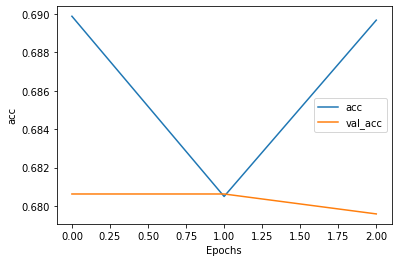

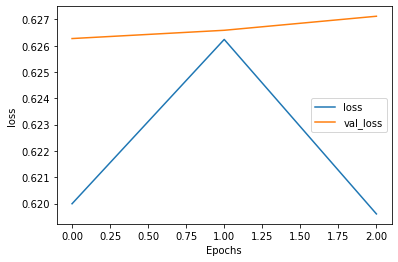

In [ ]:

# # 결과 플롯
# import matplotlib.pyplot as plt

# def plot_graphs(history, string):
#     plt.plot(history.history[string])
#     plt.plot(history.history['val_'+string], '')
#     plt.xlabel("Epochs")
#     plt.ylabel(string)
#     plt.legend([string, 'val_'+string])
#     plt.show()
# plot_graphs(history, 'acc')

# plot_graphs(history, 'loss')


In [ ]:
# 이미 Train 시킨 Model 쓰기
model_name = "GRU"
DATA_OUT_PATH = './data_out/'
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1  # 패딩을 위한 토큰인 0번 고려

SAVE_FILE_NM = 'weights.h5'

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)
model.load_weights(os.path.join(checkpoint_path))
#checkpoint_path = '/gdrive/MyDrive/movie_predict/Sentiment Analysis/data_out/GRU/weights.h5'


ValueError: ignored

In [ ]:
checkpoint_path

'./data_out/GRU/weights.h5'

In [ ]:
# Train 넣는 과정.
# 테스트 데이터 예측하기
predictions = model.predict(X_train, batch_size=512)
predictions = predictions.squeeze(-1)

# test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)
# if not os.path.exists(DATA_OUT_PATH):
#     os.makedirs(DATA_OUT_PATH)
review.reset_index(inplace = True)
review['id'] = review['index']
output = pd.DataFrame(data={"id": list(review['id']), "sentiment": list(predictions)} )
output
# output.to_csv(DATA_OUT_PATH + 'movie_review_result_cnn.csv', index=False, quoting=3)


,id,sentiment
0,0,0.705690
1,1,0.979335
2,2,0.831261
3,3,0.996311
4,4,0.929907
...,...,...
178071,178071,0.956308
178072,178072,0.364214
178073,178073,0.957525
178074,178074,0.986638


In [ ]:
output.columns = ['id',model_name]
rnn_train = output
t = pd.merge(review,rnn_train,how = 'left', on = 'id')
t.info()

In [ ]:

t.to_csv(model_name +'_score_whole.csv')
# review = pd.read_csv('RNN_score_whole.csv')
# review

# 이제 RNN whole로 주차별 점수 구하기

,Unnamed: 0,level_0,index,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,3_weeks_later,4_weeks_later,in_n_weeks,Movie_code,sentiment,id,review_pre,RNN
0,0,0,0,Actually quite funny without Chris Tucker\n,2002-03-16,Next Friday is actually pretty funny even thou...,1.0,['17 out of 25'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,195945,1,0,next friday actually pretty funny even though ...,0.689399
1,1,1,1,Some good belly laughs\n,2000-04-11,It is not easy to sit through the whole movie ...,0.7,['4 out of 5'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,195945,1,1,easy sit whole movie expect plot anything say ...,0.689399
2,2,2,2,I loved that movie\n,2000-07-25,Next Friday is a movie i enjoyed to see all 4 ...,1.0,['5 out of 7'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,195945,1,2,next friday movie enjoyed see time that movie ...,0.689399
3,3,3,3,Worst of the trilogy but still pretty funny a...,2007-06-13,"Rated R for Language,Drug Use and Sexual Conte...",0.8,['8 out of 13'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,195945,1,3,rated language drug use sexual content.next fr...,0.689399
4,4,4,4,will there be another next time???\n,2001-03-02,"i hope so. friday part one, might been more fu...",0.8,['5 out of 10'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,195945,1,4,hope friday part one might fun liked one well ...,0.689399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178071,178071,178071,178071,The Clash\n,2018-06-21,A study in tolerance and values as they clash ...,0.7,['3 out of 5'],2017-11-10,2017-11-17,2017-11-24,2017-12-01,2017-12-08,after 4 weeks,5974388,1,178071,study tolerance value clash tradition vs. cont...,0.689399
178072,178072,178072,178072,"Tiresome Throwback To The 80's, We've All Mov...",2020-09-07,In BetweenThis movie had the feel of a student...,0.4,['1 out of 2'],2017-11-10,2017-11-17,2017-11-24,2017-12-01,2017-12-08,after 4 weeks,5974388,0,178072,betweenthis movie feel student project trope s...,0.689399
178073,178073,178073,178073,An Intimate Slice of Three Palestinian Person...,2019-12-27,I love this film for three reasons: the cinema...,1.0,['1 out of 3'],2017-11-10,2017-11-17,2017-11-24,2017-12-01,2017-12-08,after 4 weeks,5974388,1,178073,love film three reason cinematography soundtra...,0.689397
178074,178074,178074,178074,Very Creepy Journey!!!\n,2020-03-21,This was one of those movies very well done. I...,0.8,['0 out of 1'],2017-09-29,2017-10-06,2017-10-13,2017-10-20,2017-10-27,after 4 weeks,3630918,1,178074,this one movie well done take psychological jo...,0.689399


# GRU 여기부터 시작! 감성점수는 다 구함. 주차별 ㄱ

In [ ]:
# review = pd.read_csv('RNN_score_whole.csv')
review = pd.read_csv('GRU_score_whole.csv')

# GRU 예측값 binary로 바꿔주기 
review['GRU'] = review['GRU']> 0.5
review['GRU'] = review['GRU'].astype('int')


## 주차별 감성 점수

  현재 CNN 으로 감성분류 결과가 나와있음.

이 후로 주차별 sentiment 점수 만들기

나는 모델별로 /무비코드/주차/ 감성(누적) 만 주면 됨.



In [ ]:
# #로드
# os.chdir('/gdrive/MyDrive/movie_predict/Sentiment Analysis')
# with open('CNN_whole','rb')as fr:
#   review = pickle.load(fr)
# review.head()

In [ ]:
# (미국기준)개봉 이전 리뷰도 1주 전 리뷰로 모아주기
def zerotoone(x):
  if x == '0':
    return '1'
  else:
    return x
review['in_n_weeks'] = review['in_n_weeks'].apply(lambda x: zerotoone(x))
review['in_n_weeks'].value_counts()

after 4 weeks    111602
1                 50926
2                  7747
3                  4585
4                  3216
Name: in_n_weeks, dtype: int64

In [ ]:
# 주차별 평점 구하기.
영화별로 주차별 평점 몇인지.
영화코드/주차별/평점 

0         after 4 weeks
1         after 4 weeks
2         after 4 weeks
3         after 4 weeks
4         after 4 weeks
              ...      
178071    after 4 weeks
178072    after 4 weeks
178073    after 4 weeks
178074    after 4 weeks
178075    after 4 weeks
Name: in_n_weeks, Length: 178076, dtype: object

In [ ]:
# 주차별 평점
group_mc_nweeks = review['GRU'].groupby([review['Movie_code'],review['in_n_weeks']]).mean().unstack()
group_mc_nweeks

in_n_weeks,1,2,3,4,after 4 weeks
Movie_code,,,,,
35423,1.000000,0.75,NaN,NaN,0.750000
113026,0.800000,NaN,NaN,NaN,0.720000
118589,NaN,NaN,NaN,NaN,0.633333
118694,1.000000,NaN,NaN,NaN,0.821429
118926,0.571429,0.00,NaN,NaN,0.818182
...,...,...,...,...,...
11023922,0.823529,1.00,1.0,NaN,1.000000
11091530,NaN,NaN,NaN,NaN,1.000000
11177112,NaN,NaN,NaN,NaN,0.500000


In [ ]:
group_mc_nweeks.reset_index( inplace = True)
group_mc_nweeks

in_n_weeks,Movie_code,1,2,3,4,after 4 weeks
0,35423,1.000000,0.75,NaN,NaN,0.750000
1,113026,0.800000,NaN,NaN,NaN,0.720000
2,118589,NaN,NaN,NaN,NaN,0.633333
3,118694,1.000000,NaN,NaN,NaN,0.821429
4,118926,0.571429,0.00,NaN,NaN,0.818182
...,...,...,...,...,...,...
7799,11023922,0.823529,1.00,1.0,NaN,1.000000
7800,11091530,NaN,NaN,NaN,NaN,1.000000
7801,11177112,NaN,NaN,NaN,NaN,0.500000
7802,11229886,1.000000,NaN,NaN,NaN,1.000000


In [ ]:
review['GRU'].groupby([review['Movie_code'],review['in_n_weeks']]).count().unstack()

in_n_weeks,1,2,3,4,after 4 weeks
Movie_code,,,,,
35423,6.0,4.0,NaN,NaN,20.0
113026,5.0,NaN,NaN,NaN,25.0
118589,NaN,NaN,NaN,NaN,30.0
118694,2.0,NaN,NaN,NaN,28.0
118926,7.0,1.0,NaN,NaN,22.0
...,...,...,...,...,...
11023922,17.0,1.0,1.0,NaN,1.0
11091530,NaN,NaN,NaN,NaN,2.0
11177112,NaN,NaN,NaN,NaN,2.0


In [ ]:
# 주차별 리뷰 수
group_mc_nweeks_count = review['GRU'].groupby([review['Movie_code'],review['in_n_weeks']]).count().unstack()
group_mc_nweeks_count = group_mc_nweeks_count.fillna(0)
group_mc_nweeks_count.reset_index(inplace = True)
# # 주차별 리뷰 수 (누적)
# group_mc_nweeks_count['2'] = group_mc_nweeks_count['1'] + group_mc_nweeks_count['2']
# group_mc_nweeks_count['3'] = group_mc_nweeks_count['2'] + group_mc_nweeks_count['3']
# group_mc_nweeks_count['4'] = group_mc_nweeks_count['3'] + group_mc_nweeks_count['4']

In [ ]:
group_mc_nweeks

in_n_weeks,Movie_code,1,2,3,4,after 4 weeks
0,35423,1.000000,0.75,NaN,NaN,0.750000
1,113026,0.800000,NaN,NaN,NaN,0.720000
2,118589,NaN,NaN,NaN,NaN,0.633333
3,118694,1.000000,NaN,NaN,NaN,0.821429
4,118926,0.571429,0.00,NaN,NaN,0.818182
...,...,...,...,...,...,...
7799,11023922,0.823529,1.00,1.0,NaN,1.000000
7800,11091530,NaN,NaN,NaN,NaN,1.000000
7801,11177112,NaN,NaN,NaN,NaN,0.500000
7802,11229886,1.000000,NaN,NaN,NaN,1.000000


In [ ]:
a = group_mc_nweeks[:40]
b = group_mc_nweeks_count[:40]
pd.concat([a,b],axis = 1)

In [ ]:
# # 누적 리뷰수
# acc_rvs = pd.DataFrame(data = [])

# acc_rvs['2'] = group_mc_nweeks_count['1'] + group_mc_nweeks_count['2']
# acc_rvs['3'] = group_mc_nweeks_count['2'] + group_mc_nweeks_count['3']
# acc_rvs['4'] = group_mc_nweeks_count['3'] + group_mc_nweeks_count['4']
# acc_rvs.reset_index(inplace = True)

# with open('acc_rvs','wb') as fw:
#   pickle.dump(acc_rvs,fw)

# print('누적 리뷰수')
# acc_rvs.head() # 누적 리뷰수

누적 리뷰수


,index,2,3,4
0,0,10.0,4.0,0.0
1,1,5.0,0.0,0.0
2,2,0.0,0.0,0.0
3,3,2.0,0.0,0.0
4,4,8.0,1.0,0.0


In [ ]:
# 누적 sentiment 점수 만들기 
temp = pd.DataFrame(data = [], columns = ['movie_code','week1sent','week2sent','week3sent','week4sent'])
temp['movie_code'] = group_mc_nweeks['Movie_code']
temp
temp['week1sent'] = group_mc_nweeks['1'] #1주차 평점
temp['week2sent'] = ((group_mc_nweeks['1'] * group_mc_nweeks_count['1']) + (group_mc_nweeks['2'] * group_mc_nweeks_count['2']))/acc_rvs['2']  #2주차 평점
temp['week3sent'] = ((group_mc_nweeks['2'] * group_mc_nweeks_count['2']) + (group_mc_nweeks['3'] * group_mc_nweeks_count['3']))/(acc_rvs['2']+group_mc_nweeks_count['3'])  #3주차 평점
temp['week4sent'] = ((group_mc_nweeks['3'] * group_mc_nweeks_count['3']) + (group_mc_nweeks['4'] * group_mc_nweeks_count['4']))/(acc_rvs['3']+group_mc_nweeks_count['4'])  #4주차 평점

In [ ]:
temp
# 지금 만든 코드는.. 앞주에 평가가 있어야만 그 다음주에 연산이됨.. NAN떄문에.
# 결측치 0 으로 채우고 연산 시도
group_mc_nweeks = group_mc_nweeks.fillna(0)
temp['week1sent'] = group_mc_nweeks['1'] #1주차 평점
temp['week2sent'] = ((group_mc_nweeks['1'] * group_mc_nweeks_count['1']) + (group_mc_nweeks['2'] * group_mc_nweeks_count['2']))/acc_rvs['2']  #2주차 평점
temp['week3sent'] = ((group_mc_nweeks['2'] * group_mc_nweeks_count['2']) + (group_mc_nweeks['3'] * group_mc_nweeks_count['3']))/(acc_rvs['2']+group_mc_nweeks_count['3'])  #3주차 평점
temp['week4sent'] = ((group_mc_nweeks['3'] * group_mc_nweeks_count['3']) + (group_mc_nweeks['4'] * group_mc_nweeks_count['4']))/(acc_rvs['3']+group_mc_nweeks_count['4'])  #4주차 평점

# 체크포인트

In [ ]:
os.chdir('/gdrive/My Drive/movie_predict/Sentiment Analysis')
os.getcwd()
# with open('group_mc_nweeks_GRU','wb') as fw:
#   pickle.dump(group_mc_nweeks,fw)

'/gdrive/My Drive/movie_predict/Sentiment Analysis'

In [ ]:
# with open('acc_rvs','wb') as fw:
#   pickle.dump(acc_rvs,fw)
# acc_rvs
# with open('group_mc_nweeks','wb') as fw:
#   pickle.dump(group_mc_nweeks,fw)
# with open('group_mc_nweeks_count','wb') as fw:
#   pickle.dump(group_mc_nweeks_count,fw)
# with open('temp','wb') as fw:
#   pickle.dump(temp,fw)



# NAN은 zero division error 떄문인거같음. 그대로 둬도 ㄱㅊ한가? 몇개 집어내서 테스트 실행.

In [ ]:
#재료 load. GRU 만들며 생성한 code
with open('group_mc_nweeks_GRU','rb') as fr:
  group_mc_nweeks = pickle.load(fr)
# with open('group_mc_nweeks_count','rb') as fr:
#   group_mc_nweeks_count = pickle.load(fr) 위에서 직접 만든걸로 쓰기
group_mc_nweeks_count
# with open('acc_rvs','rb') as fr:
#   acc_rvs = pickle.load(fr) # 이상할듯. 아래 셀로 쓰셈.


In [ ]:
# 주차 거듭할수록 누적 리뷰수
acc_rvs = pd.DataFrame(data = [])

acc_rvs['2'] = group_mc_nweeks_count['1'] + group_mc_nweeks_count['2']
acc_rvs['3'] = acc_rvs['2'] + group_mc_nweeks_count['3']
acc_rvs['4'] = acc_rvs['3'] + group_mc_nweeks_count['4']
acc_rvs.reset_index(inplace = True)
print('누적 리뷰수')
acc_rvs.head() # 누적 리뷰수

누적 리뷰수


,index,2,3,4
0,0,10.0,10.0,10.0
1,1,5.0,5.0,5.0
2,2,0.0,0.0,0.0
3,3,2.0,2.0,2.0
4,4,8.0,8.0,8.0


In [ ]:
# #0을 np.nan으로 바꾸고 얼마나 남는지 보기
# temp = temp.drop('week4sent',axis = 1) # 4주차 컬럼 없애보고 시작.
# temp = temp.fillna(0)
# temp = temp.replace([0], np.nan)
# temp.dropna()
# # 한가지 문제점. 리뷰 별점 학습 시킬때도 해당 주차에 
# # 앞주차의 감성 점수가 있으면 3200개에 해당. 

,movie_code,week1sent,week2sent,week3sent
0,35423,1.000000,0.900000,0.300000
5,120202,0.600000,0.666667,0.285714
6,120630,1.000000,1.000000,0.200000
7,120667,0.916667,0.875000,0.187500
8,120679,0.666667,0.666667,0.142857
...,...,...,...,...
7786,10550884,0.625000,0.625000,0.200000
7791,10687158,0.833333,0.846154,0.142857
7794,10764458,0.083333,0.200000,0.133333
7795,10765852,0.900000,0.909091,0.090909


In [ ]:
# acc_sent = group_mc_nweeks[['1','2','3','4']]
# acc_sent = acc_sent.replace(0,np.nan)
# acc_sent # NAN도 많고,. 실험 결과로도 rf, xg가 좋은데 이거로만 예측이제하는게 어떰?

in_n_weeks,1,2,3,4
0,1.000000,0.75,NaN,NaN
1,0.800000,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,1.000000,NaN,NaN,NaN
4,0.571429,NaN,NaN,NaN
...,...,...,...,...
7799,0.823529,1.00,1.0,NaN
7800,NaN,NaN,NaN,NaN
7801,NaN,NaN,NaN,NaN
7802,1.000000,NaN,NaN,NaN


In [ ]:
# 실험용 로드. 누적점수(평균) 구하고 없애기
import pickle
with open('group_mc_nweeks_count','rb') as fr:
  group_mc_nweeks_count = pickle.load(fr)
# group_mc_nweeks_count.dropna()
with open('group_mc_nweeks_GRU','rb') as fr:
  group_mc_nweeks = pickle.load(fr)
# group_mc_nweeks.dropna()
with open('temp','rb') as fr:
  temp = pickle.load(fr)

In [ ]:
acc_rvs.columns = ['index', 'accrv2', 'accrv3', 'accrv4']
acc_rvs.head()

,index,accrv2,accrv3,accrv4
0,0,10.0,10.0,10.0
1,1,5.0,5.0,5.0
2,2,0.0,0.0,0.0
3,3,2.0,2.0,2.0
4,4,8.0,8.0,8.0


In [ ]:
# GRU로 한거 dtype 이슈 있었음.
group_mc_nweeks['Movie_code'] = group_mc_nweeks['Movie_code'].astype('str')
group_mc_nweeks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7804 entries, 0 to 7803
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Movie_code     7804 non-null   object 
 1   1              7804 non-null   float64
 2   2              7804 non-null   float64
 3   3              7804 non-null   float64
 4   4              7804 non-null   float64
 5   after 4 weeks  7804 non-null   float64
dtypes: float64(5), object(1)
memory usage: 365.9+ KB


In [ ]:
# #f**ked up 난 Movie code 맞춰주기.. --> 일케 하면 나중에 Movie_code를 합치기 어려워지지. 다시.
# group_mc_nweeks_count['Movie_code'] = group_mc_nweeks_count['Movie_code'].astype('int')
# group_mc_nweeks_count['Movie_code'] = group_mc_nweeks_count['Movie_code'].astype('str')
# group_mc_nweeks_count

group_mc_nweeks.drop('Movie_code',axis = 1,inplace = True)
group_mc_nweeks

in_n_weeks,1,2,3,4,after 4 weeks
0,1.000000,0.75,0.0,0.0,0.750000
1,0.800000,0.00,0.0,0.0,0.720000
2,0.000000,0.00,0.0,0.0,0.633333
3,1.000000,0.00,0.0,0.0,0.821429
4,0.571429,0.00,0.0,0.0,0.818182
...,...,...,...,...,...
7799,0.823529,1.00,1.0,0.0,1.000000
7800,0.000000,0.00,0.0,0.0,1.000000
7801,0.000000,0.00,0.0,0.0,0.500000
7802,1.000000,0.00,0.0,0.0,1.000000


In [ ]:
##20210629

# Count df 컬럼 명 바꾸기
group_mc_nweeks_count.columns = ['Movie_code', 'count1', 'count2', 'count3', 'count4', 'after 4 weeks']
group_mc_nweeks_count

#Movie code 똑바로 안됐을때.
df = pd.concat([group_mc_nweeks_count,group_mc_nweeks],axis = 1)
df.head()
# df = df.replace(np.nan,0)
# acc_rv도 합쳐주기
df = pd.concat([df,acc_rvs],axis = 1)
df
# Movie Code 똑바로 저장되었을때
# # 점수 df, count df merge
# df = pd.merge(group_mc_nweeks_count,group_mc_nweeks,on = 'Movie_code', how = 'left')
# df.head()
# df = df.replace(np.nan,0)
# df


,Movie_code,count1,count2,count3,count4,after 4 weeks,1,2,3,4,after 4 weeks,index,accrv2,accrv3,accrv4
0,0035423,6.0,4.0,0.0,0.0,20.0,1.000000,0.75,0.0,0.0,0.750000,0,10.0,10.0,10.0
1,0113026,5.0,0.0,0.0,0.0,25.0,0.800000,0.00,0.0,0.0,0.720000,1,5.0,5.0,5.0
2,0118589,0.0,0.0,0.0,0.0,30.0,0.000000,0.00,0.0,0.0,0.633333,2,0.0,0.0,0.0
3,0118694,2.0,0.0,0.0,0.0,28.0,1.000000,0.00,0.0,0.0,0.821429,3,2.0,2.0,2.0
4,0118926,7.0,1.0,0.0,0.0,22.0,0.571429,0.00,0.0,0.0,0.818182,4,8.0,8.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7799,9635616,2.0,0.0,0.0,0.0,4.0,0.823529,1.00,1.0,0.0,1.000000,7799,2.0,2.0,2.0
7800,9742422,0.0,0.0,0.0,0.0,3.0,0.000000,0.00,0.0,0.0,1.000000,7800,0.0,0.0,0.0
7801,9748230,0.0,0.0,0.0,0.0,3.0,0.000000,0.00,0.0,0.0,0.500000,7801,0.0,0.0,0.0
7802,9845398,2.0,0.0,0.0,0.0,14.0,1.000000,0.00,0.0,0.0,1.000000,7802,2.0,2.0,2.0


In [ ]:
d = pd.DataFrame(data = {'1':[1,4], '2': [2,4]})
d
def dumm(one,two):
  if (one == two):
    return 'yas'
d.apply(lambda row: dumm(row['1'],row['2']),axis = 1)

0    None
1     yas
dtype: object

In [ ]:
# 부정, 리뷰 1개인데 0으로 나와서 결측치 처럼 보이는애 처리
def menozero(count,sent):
  if not (count == 0) and (sent == 0):
    sent = 0.00000001
    return sent
  else:
    return sent

df['1'] = df.apply(lambda row: menozero(row['count1'],row['1']),axis = 1)
df['2'] = df.apply(lambda row: menozero(row['count2'],row['2']),axis = 1)
df['3'] = df.apply(lambda row: menozero(row['count3'],row['3']),axis = 1)
df['4'] = df.apply(lambda row: menozero(row['count4'],row['4']),axis = 1)
df.loc[0,'2']

0.75

In [ ]:
# 여기부터 누적 점수 구하기

#mean2용.
def mean_score2(count1,count2,score1,score2):
  accr_rv = count1 + count2
  if count2 == 0:
    mean2 = score1 #나중에는 mean n = mean n-1 이런식으로. 
  else:
    mean2 = (count1 * score1 + count2 * score2)/ accr_rv
  
  return mean2

df['mean2'] = df.apply(lambda x: mean_score2(x['count1'],x['count2'],x['1'],x['2']), axis = 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7804 entries, 0 to 7803
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Movie_code     7804 non-null   object 
 1   count1         7804 non-null   float64
 2   count2         7804 non-null   float64
 3   count3         7804 non-null   float64
 4   count4         7804 non-null   float64
 5   after 4 weeks  7804 non-null   float64
 6   1              7804 non-null   float64
 7   2              7804 non-null   float64
 8   3              7804 non-null   float64
 9   4              7804 non-null   float64
 10  after 4 weeks  7804 non-null   float64
 11  index          7804 non-null   int64  
 12  accrv2         7804 non-null   float64
 13  accrv3         7804 non-null   float64
 14  accrv4         7804 non-null   float64
 15  mean2          7804 non-null   float64
dtypes: float64(14), int64(1), object(1)
memory usage: 975.6+ KB


In [ ]:
# mean 3,4 용
def mean_score(count_pre,count_next,score_pre,score_next): # count_pre, score_pre 는 누적, mean임.
  accr_rv = count_pre + count_next
  if count_next == 0:
    mean_next = score_pre 
  else:
    mean_next = (count_pre * score_pre + count_next * score_next)/ accr_rv
  
  return mean_next
#3주
df['mean3'] = df.apply(lambda x: mean_score(x['accrv2'],x['count3'],x['mean2'],x['3']), axis = 1)

#4주
df['mean4'] = df.apply(lambda x: mean_score(x['accrv3'],x['count4'],x['mean3'],x['4']), axis = 1)
df


,Movie_code,count1,count2,count3,count4,after 4 weeks,1,2,3,4,after 4 weeks,index,accrv2,accrv3,accrv4,mean2,mean3,mean4
0,0035423,6.0,4.0,0.0,0.0,20.0,1.000000e+00,7.500000e-01,0.0,0.0,0.750000,0,10.0,10.0,10.0,9.000000e-01,9.000000e-01,9.000000e-01
1,0113026,5.0,0.0,0.0,0.0,25.0,8.000000e-01,0.000000e+00,0.0,0.0,0.720000,1,5.0,5.0,5.0,8.000000e-01,8.000000e-01,8.000000e-01
2,0118589,0.0,0.0,0.0,0.0,30.0,0.000000e+00,0.000000e+00,0.0,0.0,0.633333,2,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
3,0118694,2.0,0.0,0.0,0.0,28.0,1.000000e+00,0.000000e+00,0.0,0.0,0.821429,3,2.0,2.0,2.0,1.000000e+00,1.000000e+00,1.000000e+00
4,0118926,7.0,1.0,0.0,0.0,22.0,5.714286e-01,1.000000e-08,0.0,0.0,0.818182,4,8.0,8.0,8.0,5.000000e-01,5.000000e-01,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7799,9635616,2.0,0.0,0.0,0.0,4.0,8.235294e-01,1.000000e+00,1.0,0.0,1.000000,7799,2.0,2.0,2.0,8.235294e-01,8.235294e-01,8.235294e-01
7800,9742422,0.0,0.0,0.0,0.0,3.0,0.000000e+00,0.000000e+00,0.0,0.0,1.000000,7800,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
7801,9748230,0.0,0.0,0.0,0.0,3.0,0.000000e+00,0.000000e+00,0.0,0.0,0.500000,7801,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
7802,9845398,2.0,0.0,0.0,0.0,14.0,1.000000e+00,0.000000e+00,0.0,0.0,1.000000,7802,2.0,2.0,2.0,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
#accrv_가 제대로 누적되었는지? v
# count 와 점수가 제대로 결합된건지? v

In [ ]:
with open('GRU_by_weeks','wb') as fw:
  pickle.dump(df,fw)

In [ ]:
with open('GRU_by_weeks','rb') as fr:
  df = pickle.load(fr)
df

,Movie_code,count1,count2,count3,count4,after 4 weeks,1,2,3,4,after 4 weeks,index,accrv2,accrv3,accrv4,mean2,mean3,mean4
0,0035423,6.0,4.0,0.0,0.0,20.0,1.000000e+00,7.500000e-01,0.0,0.0,0.750000,0,10.0,10.0,10.0,9.000000e-01,9.000000e-01,9.000000e-01
1,0113026,5.0,0.0,0.0,0.0,25.0,8.000000e-01,0.000000e+00,0.0,0.0,0.720000,1,5.0,5.0,5.0,8.000000e-01,8.000000e-01,8.000000e-01
2,0118589,0.0,0.0,0.0,0.0,30.0,0.000000e+00,0.000000e+00,0.0,0.0,0.633333,2,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
3,0118694,2.0,0.0,0.0,0.0,28.0,1.000000e+00,0.000000e+00,0.0,0.0,0.821429,3,2.0,2.0,2.0,1.000000e+00,1.000000e+00,1.000000e+00
4,0118926,7.0,1.0,0.0,0.0,22.0,5.714286e-01,1.000000e-08,0.0,0.0,0.818182,4,8.0,8.0,8.0,5.000000e-01,5.000000e-01,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7799,9635616,2.0,0.0,0.0,0.0,4.0,8.235294e-01,1.000000e+00,1.0,0.0,1.000000,7799,2.0,2.0,2.0,8.235294e-01,8.235294e-01,8.235294e-01
7800,9742422,0.0,0.0,0.0,0.0,3.0,0.000000e+00,0.000000e+00,0.0,0.0,1.000000,7800,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
7801,9748230,0.0,0.0,0.0,0.0,3.0,0.000000e+00,0.000000e+00,0.0,0.0,0.500000,7801,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
7802,9845398,2.0,0.0,0.0,0.0,14.0,1.000000e+00,0.000000e+00,0.0,0.0,1.000000,7802,2.0,2.0,2.0,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
# t = df[['mean2', 'mean3','mean4']] 테스트용
def mean_maker(pre_mean,next_mean):
  if np.isnan(next_mean) == True:
    next_mean = pre_mean
    return next_mean
  else:
    return next_mean

df['mean3'] = df.apply(lambda row: mean_maker(row['mean2'],row['mean3']),axis = 1)
df['mean4'] = df.apply(lambda row: mean_maker(row['mean3'],row['mean4']),axis = 1)
# 다시 0은 nan으로.
df = df.replace(0,np.nan)
df

,Movie_code,count1,count2,count3,count4,after 4 weeks,1,2,3,4,after 4 weeks,index,accrv2,accrv3,accrv4,mean2,mean3,mean4
0,0035423,6.0,4.0,NaN,NaN,20.0,1.000000e+00,7.500000e-01,NaN,NaN,0.750000,NaN,10.0,10.0,10.0,9.000000e-01,9.000000e-01,9.000000e-01
1,0113026,5.0,NaN,NaN,NaN,25.0,8.000000e-01,NaN,NaN,NaN,0.720000,1.0,5.0,5.0,5.0,8.000000e-01,8.000000e-01,8.000000e-01
2,0118589,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,0.633333,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0118694,2.0,NaN,NaN,NaN,28.0,1.000000e+00,NaN,NaN,NaN,0.821429,3.0,2.0,2.0,2.0,1.000000e+00,1.000000e+00,1.000000e+00
4,0118926,7.0,1.0,NaN,NaN,22.0,5.714286e-01,1.000000e-08,NaN,NaN,0.818182,4.0,8.0,8.0,8.0,5.000000e-01,5.000000e-01,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7799,9635616,2.0,NaN,NaN,NaN,4.0,8.235294e-01,1.000000e+00,1.0,NaN,1.000000,7799.0,2.0,2.0,2.0,8.235294e-01,8.235294e-01,8.235294e-01
7800,9742422,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,1.000000,7800.0,NaN,NaN,NaN,NaN,NaN,NaN
7801,9748230,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,0.500000,7801.0,NaN,NaN,NaN,NaN,NaN,NaN
7802,9845398,2.0,NaN,NaN,NaN,14.0,1.000000e+00,NaN,NaN,NaN,1.000000,7802.0,2.0,2.0,2.0,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7804 entries, 0 to 7803
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Movie_code     7804 non-null   object 
 1   count1         6908 non-null   float64
 2   count2         3707 non-null   float64
 3   count3         2843 non-null   float64
 4   count4         2199 non-null   float64
 5   after 4 weeks  7685 non-null   float64
 6   1              7454 non-null   float64
 7   2              4703 non-null   float64
 8   3              3737 non-null   float64
 9   4              2931 non-null   float64
 10  after 4 weeks  7607 non-null   float64
 11  index          7803 non-null   float64
 12  accrv2         7052 non-null   float64
 13  accrv3         7140 non-null   float64
 14  accrv4         7179 non-null   float64
 15  mean2          7516 non-null   float64
 16  mean3          7557 non-null   float64
 17  mean4          7572 non-null   float64
dtypes: float

저장 시 주의!

In [ ]:

# 주차별 감성 점수 저장
model = 'GRU'
GRU = df[['Movie_code','1','mean2', 'mean3', 'mean4']]
GRU.columns = ['Movie_code', 'GRU1', 'GRU2', 'GRU3', 'GRU4']
with open('score_by_weeks/'+model+'_score_by_weeks','wb') as fw:
  pickle.dump(GRU,fw)

In [ ]:
model = 'GRU'
with open('score_by_weeks/'+model+'_score_by_weeks','rb') as fr:
  c = pickle.load(fr)
c

,Movie_code,GRU1,GRU2,GRU3,GRU4
0,0035423,1.000000e+00,9.000000e-01,9.000000e-01,9.000000e-01
1,0113026,8.000000e-01,8.000000e-01,8.000000e-01,8.000000e-01
2,0118589,NaN,NaN,NaN,NaN
3,0118694,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
4,0118926,5.714286e-01,5.000000e-01,5.000000e-01,5.000000e-01
...,...,...,...,...,...
7799,9635616,8.235294e-01,8.235294e-01,8.235294e-01,8.235294e-01
7800,9742422,NaN,NaN,NaN,NaN
7801,9748230,NaN,NaN,NaN,NaN
7802,9845398,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
# c[890:1500]
c

,Movie_code,CNN1,CNN2,CNN3,CNN4
0,0035423,0.969222,0.756292,0.756292,0.756292
1,0113026,0.618794,0.618794,0.618794,0.618794
2,0118589,NaN,NaN,NaN,NaN
3,0118694,0.858872,0.858872,0.858872,0.858872
4,0118926,0.642163,0.671791,0.671791,0.671791
...,...,...,...,...,...
7799,9635616,0.881788,0.881788,0.881788,0.881788
7800,9742422,NaN,NaN,NaN,NaN
7801,9748230,NaN,NaN,NaN,NaN
7802,9845398,0.017262,0.017262,0.017262,0.017262


주차 별 리뷰 양/비율 분석

In [ ]:
review['in_n_weeks'].value_counts()

after 4 weeks    111602
1                 50926
2                  7747
3                  4585
4                  3216
Name: in_n_weeks, dtype: int64

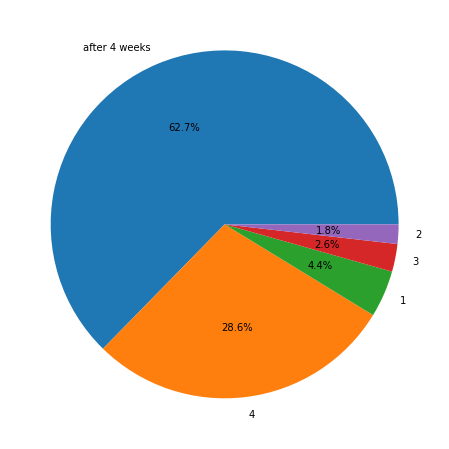

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
ratio = review['in_n_weeks'].value_counts()
labels = review['in_n_weeks'].unique()

plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show()

in_n_weeks,1,2,3,4,after 4 weeks
Movie_code,,,,,
0035423,0.969222,0.436898,NaN,NaN,0.569569
0113026,0.618794,NaN,NaN,NaN,0.381822
0118589,NaN,NaN,NaN,NaN,0.410008
0118694,0.858872,NaN,NaN,NaN,0.728970
0118926,0.642163,0.879185,NaN,NaN,0.772530
...,...,...,...,...,...
9635616,0.881788,NaN,NaN,NaN,0.937708
9742422,NaN,NaN,NaN,NaN,0.621365
9748230,NaN,NaN,NaN,NaN,0.361285


하고 다음주 평점 NAN이면 자기 평점으로 바꾸는 코드 쓰기.

In [ ]:
2주가 nan? 1주 평점으로 쓰기. 3주가? 2주로..ㅇㅇ

In [ ]:
# 1주에 리뷰없는 영화제거 6908개. 
norv1 = ~(group_mc_nweeks['1'].isna())
norv2 = ~(group_mc_nweeks['2'].isna())
norv3 = ~(group_mc_nweeks['3'].isna())
norv4 = ~(group_mc_nweeks['4'].isna())

group_mc_nweeks[norv1]

In [ ]:
# 리뷰가 한개라도 있는 영화 7179개
group_mc_nweeks[norv1|norv2|norv3|norv4]

In [ ]:
# 1~4 주 모두 리뷰가 있는 영화 899개
group_mc_nweeks.dropna()

In [ ]:
# 주차별로 평균 매기기. 
review

In [ ]:
review[['Movie_code','in_n_weeks','CNN']]

,Movie_code,in_n_weeks,CNN
0,0195945,after 4 weeks,0.346638
1,0195945,after 4 weeks,0.634306
2,0195945,after 4 weeks,0.888321
3,0195945,after 4 weeks,0.992647
4,0195945,after 4 weeks,0.913868
...,...,...,...
178071,5974388,after 4 weeks,0.957915
178072,5974388,after 4 weeks,0.042914
178073,5974388,after 4 weeks,0.960650
178074,3630918,after 4 weeks,0.997947


## (감성 분석기 Training 용) load train data reviews

이거 먼저 돌려서 Train 시키고 그 모델 그대로 test 까지.

In [ ]:
with open('/gdrive/MyDrive/movie_predict/DF/x_train_reviews','rb') as fr:
  review = pickle.load(fr)

review.reset_index(drop = True, inplace = True)
review

,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,3_weeks_later,4_weeks_later,in_n_weeks,Movie_code,sentiment
0,The Tragedy of Getting Caught in the Crossfire\n,2011-07-07,It is always difficult to tackle a war on film...,0.8,['19 out of 21'],2011-08-19,2011-08-26,2011-09-02,2011-09-09,2011-09-16,0,1562847,1
1,Best Sayles movie since Lone Star\n,2011-04-29,I saw this movie at the film festival Copenhag...,0.9,['20 out of 24'],2011-08-19,2011-08-26,2011-09-02,2011-09-09,2011-09-16,0,1562847,1
2,Fighting the Good Fight!\n,2010-09-15,John Sayles is the heart and soul of independe...,0.9,['27 out of 36'],2011-08-19,2011-08-26,2011-09-02,2011-09-09,2011-09-16,0,1562847,1
3,Providing Perspective\n,2012-04-08,"Being an American, I have taken my fair share ...",0.9,['7 out of 8'],2011-08-19,2011-08-26,2011-09-02,2011-09-09,2011-09-16,after 4 weeks,1562847,1
4,Thought it was just okay\n,2011-08-22,"Without a doubt, a movie about this subject ne...",0.7,['10 out of 13'],2011-08-19,2011-08-26,2011-09-02,2011-09-09,2011-09-16,1,1562847,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
142672,Decent if unspectacular cat 'n mouse horror t...,2010-12-29,"Before P2, I never would have thought an under...",0.7,['5 out of 8'],2007-11-09,2007-11-16,2007-11-23,2007-11-30,2007-12-07,after 4 weeks,0804516,1
142673,"OK, its really, really bad\n",2007-11-14,i'm sorry all who like to think they can give ...,0.2,['14 out of 30'],2007-11-09,2007-11-16,2007-11-23,2007-11-30,2007-12-07,1,0804516,0
142674,Very good thriller.\n,2019-06-15,"No dull moments, kept me watching, as woman ge...",0.8,['3 out of 4'],2007-11-09,2007-11-16,2007-11-23,2007-11-30,2007-12-07,after 4 weeks,0804516,1
142675,who wrote for this movie\n,2007-12-18,I have seen many disgusting and no point movie...,0.1,['12 out of 25'],2007-11-09,2007-11-16,2007-11-23,2007-11-30,2007-12-07,after 4 weeks,0804516,0


In [ ]:
# contents가 nan 이면 제거하는 코드
review.dropna(axis = 0,inplace = True)
review.reset_index(drop = True, inplace = True)
print(review.shape)
review.head()


(142670, 13)


,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,3_weeks_later,4_weeks_later,in_n_weeks,Movie_code,sentiment
0,The Tragedy of Getting Caught in the Crossfire\n,2011-07-07,It is always difficult to tackle a war on film...,0.8,['19 out of 21'],2011-08-19,2011-08-26,2011-09-02,2011-09-09,2011-09-16,0,1562847,1
1,Best Sayles movie since Lone Star\n,2011-04-29,I saw this movie at the film festival Copenhag...,0.9,['20 out of 24'],2011-08-19,2011-08-26,2011-09-02,2011-09-09,2011-09-16,0,1562847,1
2,Fighting the Good Fight!\n,2010-09-15,John Sayles is the heart and soul of independe...,0.9,['27 out of 36'],2011-08-19,2011-08-26,2011-09-02,2011-09-09,2011-09-16,0,1562847,1
3,Providing Perspective\n,2012-04-08,"Being an American, I have taken my fair share ...",0.9,['7 out of 8'],2011-08-19,2011-08-26,2011-09-02,2011-09-09,2011-09-16,after 4 weeks,1562847,1
4,Thought it was just okay\n,2011-08-22,"Without a doubt, a movie about this subject ne...",0.7,['10 out of 13'],2011-08-19,2011-08-26,2011-09-02,2011-09-09,2011-09-16,1,1562847,1


# (1)(감성분석기 TEST 용) load test_data review

movie code가 test data에 해당하는 것만 가져오기

In [ ]:
path = '/gdrive/MyDrive/movie_predict/DF/'+'all_reviews'
with open(path,'rb') as fr:
  review = pickle.load(fr)
review.reset_index(drop = True,inplace = True)

In [ ]:
#train movie code 가져오는 코드

with open('/gdrive/MyDrive/movie_predict/other entities/x_train_movie_code','rb') as fr:
  train_movie_code = pickle.load(fr)
# train_movie_code

def is_test_movie_code(movie_code):
  test = not movie_code in train_movie_code
  return test

test_bool = review['Movie_code'].apply(lambda x: is_test_movie_code(x))
review = review[test_bool] #이제 밑에 preprocess하셈
review


,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,3_weeks_later,4_weeks_later,in_n_weeks,Movie_code,sentiment
180,Stressed out\n,2006-02-06,"No wonder Charlie, the man at the center of th...",0.7,['28 out of 33'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1
181,Brilliant but poor marketing...\n,2004-05-02,"This gem hit box offices in 2000, though there...",1.0,['32 out of 41'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1
182,great sublime satire...\n,2001-02-21,what is wrong with this film? absolutely nothi...,0.7,['25 out of 34'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1
183,And You Thought You Had It Tough?\n,2002-04-11,"Stress. It comes in many shapes and sizes, to ...",0.8,['17 out of 25'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1
184,"Within the great adversities of life, this fl...",2006-08-05,"Gun Shy is apt title! This underrated comedy, ...",0.8,['17 out of 26'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
177868,One of the worst films I've ever watched\n,2020-10-31,The movie had a good cast but was absolutely a...,0.1,['1 out of 1'],2017-12-22,2017-12-29,2018-01-05,2018-01-12,2018-01-19,after 4 weeks,1966359,0
177869,Enjoyable\n,2018-04-05,Father figures isn't ground breaking but enjoy...,0.7,['1 out of 1'],2017-12-22,2017-12-29,2018-01-05,2018-01-12,2018-01-19,after 4 weeks,1966359,1
177870,"Boring, Not funny and Vulgar. The actors shou...",2018-01-02,"I agree with another poster that said ""don't w...",0.2,['13 out of 40'],2017-12-22,2017-12-29,2018-01-05,2018-01-12,2018-01-19,2,1966359,0
178083,Very Creepy Journey!!!\n,2020-03-21,This was one of those movies very well done. I...,0.8,['0 out of 1'],2017-09-29,2017-10-06,2017-10-13,2017-10-20,2017-10-27,after 4 weeks,3630918,1


In [ ]:
# test_index = list(review.index)
# with open('Train_Test/test_index','wb') as fw:
#   pickle.dump(test_index,fw)
with open('Train_Test/test_index','rb') as fr:
  test_index =pickle.load(fr)
test_index


In [ ]:
review[test_]

# analysis

In [ ]:
review['str_contents'] = review['contents'].apply(lambda x: str(x))

In [ ]:
import matplotlib.pyplot as plt
# word cloud
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600).generate(" ".join(review['str_contents']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

KeyboardInterrupt: ignored

In [ ]:
SA_model = 'sentiword_net'
df = review[['Movie_code',SA_model]]


# movie_code 별 영화 평균 감성 점수 구하기
mean_sa = df.groupby('Movie_code').mean()
mean_sa


KeyError: ignored

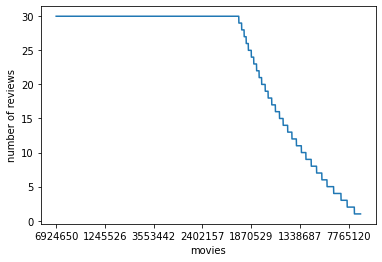

In [ ]:
df['Movie_code'].value_counts()[df['Movie_code'].value_counts() < 31]
df['Movie_code'].value_counts().plot(xlabel = 'movies',ylabel = 'number of reviews')

In [ ]:
review['words'] = review['contents'].apply(lambda x: len(x.split(' ')))
review['words'].mean()
review['words'].median()
review['words'].min()


In [ ]:

plt.figure(figsize=(15, 10))
plt.title('Histogram of word count',fontsize=25)
plt.xlabel('Number of words', fontsize=25)
plt.ylabel('Number of reviews', fontsize=25)

plt.hist(review['words'], bins = 100, label = 'word counts') #
plt.yscale('log', nonposy='clip') # nonposy = 'clip' => non-positive 값을 아주 작은 값으로 자름.

plt.plot([216,216], [0,15000],label = 'mean',c = 'r')
plt.plot([160,160], [0,15000],label = 'median',c = 'k')
plt.legend(loc='upper right',fontsize = 15)

# Unsupervised Approach

## 1.SentiWordnet

In [ ]:

# 간단한 NTLK PennTreebank Tag를 기반으로 WordNet기반의 품사 Tag로 변환
def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return 

In [ ]:
#원본
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

def swn_polarity(text):
    # 감성 지수 초기화 
    sentiment = 0.0
    tokens_count = 0
    
    lemmatizer = WordNetLemmatizer()
    raw_sentences = sent_tokenize(text)
    # 분해된 문장별로 단어 토큰 -> 품사 태깅 후에 SentiSynset 생성 -> 감성 지수 합산 
    for raw_sentence in raw_sentences:
        # NTLK 기반의 품사 태깅 문장 추출  
        tagged_sentence = pos_tag(word_tokenize(raw_sentence))
        #print(tagged_sentence)
        for word , tag in tagged_sentence:
            #print('tag',tag)
            # WordNet 기반 품사 태깅과 어근 추출
            wn_tag = penn_to_wn(tag) #nltk>wordnet기반으로 바꿔주기. 호환이 되네..
            #print('wn_tag',wn_tag)
            if wn_tag not in (wn.NOUN , wn.ADJ, wn.ADV):
                continue                   
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            #print('lemma',lemma)
            if not lemma:
                #print('not lemma',lemma)
                continue
            # 어근을 추출한 단어와 WordNet 기반 품사 태깅을 입력해 Synset 객체를 생성. 
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
            # sentiwordnet의 감성 단어 분석으로 감성 synset 추출
            # 모든 단어에 대해 긍정 감성 지수는 +로 부정 감성 지수는 -로 합산해 감성 지수 계산. 
            synset = synsets[0]
            #print('synset',synset)
            #print(synset.name())
            swn_synset = swn.senti_synset(synset.name())
            #print('swn_synset',swn_synset)
            sentiment += (swn_synset.pos_score() - swn_synset.neg_score())           
            tokens_count += 1
    
    if not tokens_count:
        return 0
    
    # 총 score가 0 이상일 경우 긍정(Positive) 1, 그렇지 않을 경우 부정(Negative) 0 반환
    if sentiment >= 0 :
        return 1
    
    return 0


In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

def swn_polarity(text):
    # 감성 지수 초기화 
    sentiment = 0.0
    tokens_count = 0
    try:
      
      lemmatizer = WordNetLemmatizer()
      raw_sentences = sent_tokenize(text)
      # 분해된 문장별로 단어 토큰 -> 품사 태깅 후에 SentiSynset 생성 -> 감성 지수 합산 
      for raw_sentence in raw_sentences:
          # NTLK 기반의 품사 태깅 문장 추출  
          tagged_sentence = pos_tag(word_tokenize(raw_sentence))
          #print(tagged_sentence)
          for word , tag in tagged_sentence:
              #print('tag',tag)
              # WordNet 기반 품사 태깅과 어근 추출
              wn_tag = penn_to_wn(tag) #nltk>wordnet기반으로 바꿔주기. 호환이 되네..
              #print('wn_tag',wn_tag)
              if wn_tag not in (wn.NOUN , wn.ADJ, wn.ADV):
                  continue                   
              lemma = lemmatizer.lemmatize(word, pos=wn_tag)
              #print('lemma',lemma)
              if not lemma:
                  #print('not lemma',lemma)
                  continue
              # 어근을 추출한 단어와 WordNet 기반 품사 태깅을 입력해 Synset 객체를 생성. 
              synsets = wn.synsets(lemma, pos=wn_tag)
              if not synsets:
                  continue
              # sentiwordnet의 감성 단어 분석으로 감성 synset 추출
              # 모든 단어에 대해 긍정 감성 지수는 +로 부정 감성 지수는 -로 합산해 감성 지수 계산. 
              synset = synsets[0]
              #print('synset',synset)
              #print(synset.name())
              swn_synset = swn.senti_synset(synset.name())
              #print('swn_synset',swn_synset)
              sentiment += (swn_synset.pos_score() - swn_synset.neg_score())           
              tokens_count += 1
      
      if not tokens_count:
          return 0
      
      # 총 score가 0 이상일 경우 긍정(Positive) 1, 그렇지 않을 경우 부정(Negative) 0 반환
      if sentiment >= 0 :
          return 1
      
      return 0
    except:
      print(text)
#에러 자꾸 nan 0 이거 뭐임? **&&

In [ ]:
import time
begin = time.time()

review['preds'] = review['contents'].apply( lambda x : swn_polarity(x))
review.dropna(inplace = True)
review['preds'] = review['preds'].apply(lambda x: int(x)) # binary로 바꿔줌
review['sentiment'] = review['sentiment'].apply(lambda x: int(x)) # binary로 바꿔줌
y_target = review['sentiment'].values
preds = review['preds'].values


end = time.time()
print(np.round((end - begin)/60),"분 소요")

nan
nan
9.0 분 소요


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, plot_confusion_matrix
from sklearn.metrics import recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test=None, pred=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
print('#### SentiWordNet 예측 성능 평가 ####')
get_clf_eval(y_target, preds)

# nan 처리. **

#### SentiWordNet 예측 성능 평가 ####
오차 행렬
[[31844 23690]
 [30523 92016]]
정확도: 0.6956, 정밀도: 0.7953, 재현율: 0.7509,    F1: 0.7724, AUC:0.6622


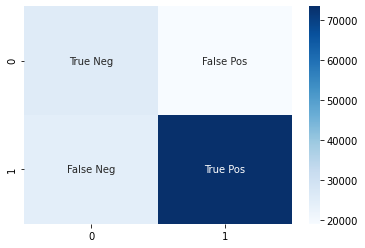

In [ ]:
import seaborn as sns

labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')

In [ ]:
# # 별로 안예쁨..
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# #label=['positive','negative'] # 라벨 설정

# # Visualize confusion matrix 오차행렬 시각화
# plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.gray)
# plt.title('Confusion matrix')
# plt.colorbar()
# ticks = np.arange(2)      #ticks : 클래스의 수 여기선 레이블을 5가지로 구분
# plt.xticks(ticks, ticks) 
# plt.yticks(ticks, ticks)
# plt.ylabel('True labels')
# plt.xlabel('Predicted labels')
# plt.show()

In [ ]:
review

,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,3_weeks_later,4_weeks_later,in_n_weeks,Movie_code,sentiment,preds
180,Stressed out\n,2006-02-06,"No wonder Charlie, the man at the center of th...",0.7,['28 out of 33'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,1.0
181,Brilliant but poor marketing...\n,2004-05-02,"This gem hit box offices in 2000, though there...",1.0,['32 out of 41'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,1.0
182,great sublime satire...\n,2001-02-21,what is wrong with this film? absolutely nothi...,0.7,['25 out of 34'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,1.0
183,And You Thought You Had It Tough?\n,2002-04-11,"Stress. It comes in many shapes and sizes, to ...",0.8,['17 out of 25'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,1.0
184,"Within the great adversities of life, this fl...",2006-08-05,"Gun Shy is apt title! This underrated comedy, ...",0.8,['17 out of 26'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177868,One of the worst films I've ever watched\n,2020-10-31,The movie had a good cast but was absolutely a...,0.1,['1 out of 1'],2017-12-22,2017-12-29,2018-01-05,2018-01-12,2018-01-19,after 4 weeks,1966359,0,0.0
177869,Enjoyable\n,2018-04-05,Father figures isn't ground breaking but enjoy...,0.7,['1 out of 1'],2017-12-22,2017-12-29,2018-01-05,2018-01-12,2018-01-19,after 4 weeks,1966359,1,1.0
177870,"Boring, Not funny and Vulgar. The actors shou...",2018-01-02,"I agree with another poster that said ""don't w...",0.2,['13 out of 40'],2017-12-22,2017-12-29,2018-01-05,2018-01-12,2018-01-19,2,1966359,0,0.0
178083,Very Creepy Journey!!!\n,2020-03-21,This was one of those movies very well done. I...,0.8,['0 out of 1'],2017-09-29,2017-10-06,2017-10-13,2017-10-20,2017-10-27,after 4 weeks,3630918,1,1.0


In [ ]:
review['senti'] = review['preds']
df = review[['senti','Movie_code','in_n_weeks']]
df

,senti,Movie_code,in_n_weeks
180,1.0,0171356,after 4 weeks
181,1.0,0171356,after 4 weeks
182,1.0,0171356,after 4 weeks
183,1.0,0171356,after 4 weeks
184,1.0,0171356,after 4 weeks
...,...,...,...
177868,0.0,1966359,after 4 weeks
177869,1.0,1966359,after 4 weeks
177870,0.0,1966359,2
178083,1.0,3630918,after 4 weeks


리뷰 별 감성 예측값 저장

In [ ]:
with open('/gdrive/MyDrive/movie_predict/DF/sentiwordnet_pred','wb') as fw:
  pickle.dump(df,fw)


In [ ]:
with open('/gdrive/MyDrive/movie_predict/DF/sentiwordnet_pred','rb') as fr:
  sw = pickle.load(fr)
sw

,senti,Movie_code,in_n_weeks
180,1.0,0171356,after 4 weeks
181,1.0,0171356,after 4 weeks
182,1.0,0171356,after 4 weeks
183,1.0,0171356,after 4 weeks
184,1.0,0171356,after 4 weeks
...,...,...,...
177868,0.0,1966359,after 4 weeks
177869,1.0,1966359,after 4 weeks
177870,0.0,1966359,2
178083,1.0,3630918,after 4 weeks


In [ ]:
sw.reset_index(inplace= True)
sw

,index,senti,Movie_code,in_n_weeks
0,180,1.0,0171356,after 4 weeks
1,181,1.0,0171356,after 4 weeks
2,182,1.0,0171356,after 4 weeks
3,183,1.0,0171356,after 4 weeks
4,184,1.0,0171356,after 4 weeks
...,...,...,...,...
35403,177868,0.0,1966359,after 4 weeks
35404,177869,1.0,1966359,after 4 weeks
35405,177870,0.0,1966359,2
35406,178083,1.0,3630918,after 4 weeks


영화별 평균 감성값(큰 의미 X)

In [ ]:
review['sentiword_net'] = review['preds']

In [ ]:
SA_model = 'sentiword_net'
df = review[['Movie_code',SA_model]]


# movie_code 별 영화 평균 감성 점수 구하기
df = df.groupby('Movie_code').mean()
df

,sentiword_net
Movie_code,
0035423,0.833333
0113026,0.533333
0118589,0.400000
0118694,0.766667
0118926,0.566667
...,...
9635616,0.666667
9742422,0.333333
9748230,1.000000


In [ ]:
with open('/gdrive/MyDrive/movie_predict/DF/sentiwordnet','wb') as fw:
  pickle.dump(df,fw)


In [ ]:
with open('/gdrive/MyDrive/movie_predict/DF/sentiwordnet','rb') as fr:
  test = pickle.load(fr)
test

,sentiword_net
Movie_code,
0035423,0.833333
0113026,0.533333
0118589,0.400000
0118694,0.766667
0118926,0.566667
...,...
9635616,0.666667
9742422,0.333333
9748230,1.000000


##2.VADER

In [ ]:
# VADER 테스트

from nltk.sentiment.vader import SentimentIntensityAnalyzer\


senti_analyzer = SentimentIntensityAnalyzer()
sent = "screw you"
#sent = "what you doin min?"
senti_score = senti_analyzer.polarity_scores(sent)
senti_score



/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


{'compound': -0.1027, 'neg': 0.583, 'neu': 0.417, 'pos': 0.0}

In [ ]:
path = '/gdrive/MyDrive/movie_predict/DF/'+'all_reviews'
with open(path,'rb') as fr:
  review_df = pickle.load(fr)
review_df.head()

,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,3_weeks_later,4_weeks_later,in_n_weeks,Movie_code,sentiment
0,Actually quite funny without Chris Tucker\n,2002-03-16,Next Friday is actually pretty funny even thou...,1.0,['17 out of 25'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1
3,Some good belly laughs\n,2000-04-11,It is not easy to sit through the whole movie ...,0.7,['4 out of 5'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1
4,I loved that movie\n,2000-07-25,Next Friday is a movie i enjoyed to see all 4 ...,1.0,['5 out of 7'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1
5,Worst of the trilogy but still pretty funny a...,2007-06-13,"Rated R for Language,Drug Use and Sexual Conte...",0.8,['8 out of 13'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1
9,will there be another next time???\n,2001-03-02,"i hope so. friday part one, might been more fu...",0.8,['5 out of 10'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1


In [ ]:
review_df = review
review_df['contents'] = review_df['contents'].apply(lambda x: str(x))

In [ ]:
begin = time.time()
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, plot_confusion_matrix
from sklearn.metrics import recall_score, f1_score, roc_auc_score


def vader_polarity(review,threshold=0.1):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(review)
    
    # compound 값에 기반하여 threshold 입력값보다 크면 1, 그렇지 않으면 0을 반환 
    agg_score = scores['compound']
    final_sentiment = 1 if agg_score >= threshold else 0
    return final_sentiment

# apply lambda 식을 이용하여 레코드별로 vader_polarity( )를 수행하고 결과를 'vader_preds'에 저장
#review['preds'] = review['contents'].apply( lambda x : swn_polarity(x))

review_df['vader_preds'] = review_df['contents'].apply(lambda x : vader_polarity(x, 0.1))

review_df['vader_preds'] = review_df['vader_preds'].apply(lambda x: int(x)) # binary로 바꿔줌
review_df['sentiment'] = review_df['sentiment'].apply(lambda x: int(x)) # binary로 바꿔줌

y_target = review_df['sentiment'].values
vader_preds = review_df['vader_preds'].values

confusion = confusion_matrix( y_target, vader_preds)
print(confusion)
print("정확도:", np.round(accuracy_score(y_target , vader_preds),4))
print("정밀도:", np.round(precision_score(y_target , vader_preds),4))
print("재현율:", np.round(recall_score(y_target, vader_preds),4))

end = time.time()
print(np.round((end - begin)/60),"분 소요")

[[ 5726  5171]
 [ 2861 21650]]
정확도: 0.7732
정밀도: 0.8072
재현율: 0.8833
6.0 분 소요


In [ ]:
def get_clf_eval(y_test=None, pred=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
print('#### SentiWordNet 예측 성능 평가 ####')
get_clf_eval(y_target, vader_preds)

# nan 처리. **

#### SentiWordNet 예측 성능 평가 ####
오차 행렬
[[ 29262  26274]
 [ 14705 107844]]
정확도: 0.7699, 정밀도: 0.8041, 재현율: 0.8800,    F1: 0.8403, AUC:0.7035


In [ ]:
#  df학습 폴더: test에도 잘 들어갔나 확인
review_df = review_df[['Movie_code','vader_preds']]
review_df

,Movie_code,vader_preds
0,0195945,1
3,0195945,0
4,0195945,1
5,0195945,1
9,0195945,1
...,...,...
1363405,5974388,0
1363406,5974388,1
1363407,5974388,1
1363408,3630918,1


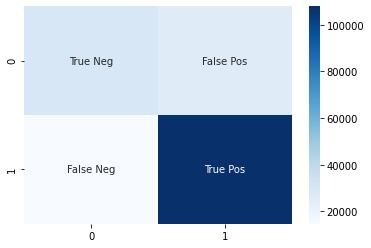

In [ ]:
confusion = confusion_matrix( y_target, vader_preds)

import seaborn as sns
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')

In [ ]:
# 기존 df에 추가를 위해 저-장
SA_model = 'VADER'
# df = review[['Movie_code',SA_model]]
path = '/gdrive/MyDrive/movie_predict/DF/'+ SA_model
with open(path,'wb') as fw:
  pickle.dump(review_df,fw)

In [ ]:

# 저장확인
with open(path,'rb') as fr:
  test = pickle.load(fr)
test

,Movie_code,vader_preds
0,0195945,1
3,0195945,0
4,0195945,1
5,0195945,1
9,0195945,1
...,...,...
1363405,5974388,0
1363406,5974388,1
1363407,5974388,1
1363408,3630918,1


리뷰별 감성 예측값 저장

In [ ]:
df = review[['vader_preds','Movie_code','in_n_weeks']]
df

,vader_preds,Movie_code,in_n_weeks
180,1,0171356,after 4 weeks
181,1,0171356,after 4 weeks
182,1,0171356,after 4 weeks
183,1,0171356,after 4 weeks
184,1,0171356,after 4 weeks
...,...,...,...
177868,0,1966359,after 4 weeks
177869,1,1966359,after 4 weeks
177870,0,1966359,2
178083,1,3630918,after 4 weeks


In [ ]:
# 기존 df에 추가를 위해 저-장
SA_model = 'VADER_test'
# df = review[['Movie_code',SA_model]]
path = '/gdrive/MyDrive/movie_predict/DF/'+ SA_model
with open(path,'wb') as fw:
  pickle.dump(df,fw)

In [ ]:
# 저장확인
with open(path,'rb') as fr:
  vader = pickle.load(fr)
vader

,vader_preds,Movie_code,in_n_weeks
180,1,0171356,after 4 weeks
181,1,0171356,after 4 weeks
182,1,0171356,after 4 weeks
183,1,0171356,after 4 weeks
184,1,0171356,after 4 weeks
...,...,...,...
177868,0,1966359,after 4 weeks
177869,1,1966359,after 4 weeks
177870,0,1966359,2
178083,1,3630918,after 4 weeks


# Supervised Approach

### Preprocessing

#### train data preprocessing

In [ ]:
# str로 변경
review['contents'] = review['contents'].apply(lambda x: str(x))

def preprocessing( review, remove_stopwords = False ): 
    # 불용어 제거는 옵션으로 선택 가능하다.
    
    # 1. HTML 태그 제거
    review_text = BeautifulSoup(review, "html5lib").get_text()	

    # 2. 영어가 아닌 특수문자들을 공백(" ")으로 바꾸기
    review_text = re.sub("[^a-zA-Z]", " ", review_text)

    # 3. 대문자들을 소문자로 바꾸고 공백단위로 텍스트들 나눠서 리스트로 만든다.
    words = review_text.lower().split()

    if remove_stopwords: 
        # 4. 불용어들을 제거
    
        #영어에 관련된 불용어 불러오기
        stops = set(stopwords.words("english"))
        # 불용어가 아닌 단어들로 이루어진 새로운 리스트 생성
        words = [w for w in words if not w in stops]
        # 5. 단어 리스트를 공백을 넣어서 하나의 글로 합친다.	
        clean_review = ' '.join(words)

    else: # 불용어 제거하지 않을 때
        clean_review = ' '.join(words)

    return clean_review

clean_train_reviews = []
for rv in review['contents']:
    clean_train_reviews.append(preprocessing(rv, remove_stopwords = True))


KeyboardInterrupt: ignored

In [ ]:
# 전처리한 데이터 출력

clean_train_df = pd.DataFrame({'review': clean_train_reviews, 'sentiment': review['sentiment']})

tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_reviews)
text_sequences = tokenizer.texts_to_sequences(clean_train_reviews)
print(text_sequences[0])


[107, 539, 6490, 191, 2, 1234, 957, 323, 3988, 2382, 20118, 135, 3966, 2279, 9337, 1657, 1536, 9475, 111, 45, 3, 8, 3076, 34323, 2244, 52, 257, 12899, 1076, 131, 1657, 2550, 1628, 1272, 29377, 180, 191, 2, 546, 51, 66, 366, 607, 1084, 3686, 55478, 15108, 2325, 438, 98, 180, 1317, 876, 8623, 11116, 14051, 8125, 29378, 82, 1018, 3769, 1722, 402, 2992, 86172, 157, 3596, 7132, 15728, 70052, 3049, 30780, 1562, 12262, 86173, 3332, 27549, 16, 1761, 25140, 17865, 19405, 1385, 86174, 1283, 18255, 1315, 945, 17676, 16578, 1955, 3584, 1390, 12262, 511, 1866, 7370, 31545, 7, 1674, 3754, 21901, 3364, 12899, 14155, 51, 1009, 20, 114, 7, 20, 2974, 77, 820, 229, 568, 61301, 1761, 2713, 1048, 130, 1244, 358, 450, 102, 1, 2532, 847, 4166, 439, 3996, 5, 329, 5246, 241, 10, 3546, 5161, 44, 643, 709, 5280, 187, 68, 96, 1263, 418, 172, 114, 134, 33321, 2735, 3364, 507, 1292, 23, 12262, 1015, 1335, 1831, 30780, 511, 933, 17676, 4493, 3332, 27549, 2884, 1619, 12262, 2200, 183, 18632, 1135, 194, 154, 9014, 34,

In [ ]:
word_vocab = tokenizer.word_index
word_vocab["<PAD>"] = 0

print("전체 단어 개수: ", len(word_vocab))

word_vocab

data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)


전체 단어 개수:  146612


In [ ]:
#패딩

MAX_SEQUENCE_LENGTH = 512
train_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print('Shape of train data: ', train_inputs.shape)


Shape of train data:  (142670, 512)


In [ ]:
# 레이블 정보를 numpy 배열로
train_labels = np.array(review['sentiment'])
print('Shape of label tensor:', train_labels.shape)


Shape of label tensor: (142670,)


In [ ]:
os.chdir('/gdrive/MyDrive/movie_predict/Sentiment Analysis')
# 결과 저장
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
TRAIN_CLEAN_DATA = 'train_clean.csv'
DATA_CONFIGS = 'data_configs.json'

DATA_IN_PATH = './data_in/'

import os
# 저장하는 디렉토리가 존재하지 않으면 생성
if not os.path.exists(DATA_IN_PATH):
    os.makedirs(DATA_IN_PATH)

In [ ]:
# 전처리 된 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
# np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels) # 안됨
with open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb') as fw:
  pickle.dump(train_labels,fw)

In [ ]:
clean_train_df
# 정제된 텍스트를 csv 형태로 저장
clean_train_df.to_csv(DATA_IN_PATH + TRAIN_CLEAN_DATA, index = False)


# 데이터 사전을 json 형태로 저장
json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'), ensure_ascii=False)


하고 training으로 넘어가기 test는 train 끝나고 따로

#### (2)Test data preprocessing

주의! 그냥 돌리지말고 path 바꿔주기.

In [ ]:
review.reset_index(inplace = True)
review['id'] = review['index']
review

,index,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,3_weeks_later,4_weeks_later,in_n_weeks,Movie_code,sentiment,id
0,180,Stressed out\n,2006-02-06,"No wonder Charlie, the man at the center of th...",0.7,['28 out of 33'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,180
1,181,Brilliant but poor marketing...\n,2004-05-02,"This gem hit box offices in 2000, though there...",1.0,['32 out of 41'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,181
2,182,great sublime satire...\n,2001-02-21,what is wrong with this film? absolutely nothi...,0.7,['25 out of 34'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,182
3,183,And You Thought You Had It Tough?\n,2002-04-11,"Stress. It comes in many shapes and sizes, to ...",0.8,['17 out of 25'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,183
4,184,"Within the great adversities of life, this fl...",2006-08-05,"Gun Shy is apt title! This underrated comedy, ...",0.8,['17 out of 26'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35403,177868,One of the worst films I've ever watched\n,2020-10-31,The movie had a good cast but was absolutely a...,0.1,['1 out of 1'],2017-12-22,2017-12-29,2018-01-05,2018-01-12,2018-01-19,after 4 weeks,1966359,0,177868
35404,177869,Enjoyable\n,2018-04-05,Father figures isn't ground breaking but enjoy...,0.7,['1 out of 1'],2017-12-22,2017-12-29,2018-01-05,2018-01-12,2018-01-19,after 4 weeks,1966359,1,177869
35405,177870,"Boring, Not funny and Vulgar. The actors shou...",2018-01-02,"I agree with another poster that said ""don't w...",0.2,['13 out of 40'],2017-12-22,2017-12-29,2018-01-05,2018-01-12,2018-01-19,2,1966359,0,177870
35406,178083,Very Creepy Journey!!!\n,2020-03-21,This was one of those movies very well done. I...,0.8,['0 out of 1'],2017-09-29,2017-10-06,2017-10-13,2017-10-20,2017-10-27,after 4 weeks,3630918,1,178083


In [ ]:

def preprocessing( review, remove_stopwords = False ): 
    # 불용어 제거는 옵션으로 선택 가능하다.
    
    # 1. HTML 태그 제거
    review_text = BeautifulSoup(review, "html5lib").get_text()	

    # 2. 영어가 아닌 특수문자들을 공백(" ")으로 바꾸기
    review_text = re.sub("[^a-zA-Z]", " ", review_text)

    # 3. 대문자들을 소문자로 바꾸고 공백단위로 텍스트들 나눠서 리스트로 만든다.
    words = review_text.lower().split()

    if remove_stopwords: 
        # 4. 불용어들을 제거
    
        #영어에 관련된 불용어 불러오기
        stops = set(stopwords.words("english"))
        # 불용어가 아닌 단어들로 이루어진 새로운 리스트 생성
        words = [w for w in words if not w in stops]
        # 5. 단어 리스트를 공백을 넣어서 하나의 글로 합친다.	
        clean_review = ' '.join(words)

    else: # 불용어 제거하지 않을 때
        clean_review = ' '.join(words)

    return clean_review


In [ ]:
# 테스트 데이터 처리
review['contents'] = review['contents'].apply(lambda x: str(x))
clean_test_reviews = []
for rv in review['contents']:
    clean_test_reviews.append(preprocessing(rv, remove_stopwords = True))


clean_test_df = pd.DataFrame({'review': clean_test_reviews, 'id': review['id'],'sentiment':review['sentiment']})
test_id = np.array(review['id'])

text_sequences = tokenizer.texts_to_sequences(clean_test_reviews)
test_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

TEST_INPUT_DATA = 'test_input.npy'
TEST_CLEAN_DATA = 'test_clean.csv'
TEST_ID_DATA = 'test_id.npy'

np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
# np.save(open(DATA_IN_PATH + TEST_ID_DATA, 'wb'), test_id)
with open(DATA_IN_PATH + TEST_ID_DATA, 'wb') as fw:
  pickle.dump(test_id,fw)

clean_test_df.to_csv(DATA_IN_PATH + TEST_CLEAN_DATA, index = False)


KeyboardInterrupt: ignored

#### loading preprocessed data

Whole

##### Train

In [ ]:
#전처리한 데이터 불러오기
os.chdir('/gdrive/MyDrive/movie_predict/Sentiment Analysis')
# 학습 데이터 경로 정의
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

# 랜덤 시드 고정
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [ ]:
#로드, 
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))
train_data = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
# target_date = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
with open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb') as fr:
  target_data = pickle.load(fr)

target_data

array([1, 1, 1, ..., 1, 0, 1], dtype=object)

In [ ]:
# (필요 없음)
# #Train, Test split


# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(train_data, target_data, test_size=0.2,random_state = 0) 

# y_test = np.array(y_test).reshape(-1,1)
# print('train:',x_train.shape)
# print('test:',x_test.shape)

##### (3)Test

Test data 로 성능 평가용 데이터 준비 

In [ ]:
# test data 불러오기
review

,index,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,3_weeks_later,4_weeks_later,in_n_weeks,Movie_code,sentiment,id
0,180,Stressed out\n,2006-02-06,"No wonder Charlie, the man at the center of th...",0.7,['28 out of 33'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,180
1,181,Brilliant but poor marketing...\n,2004-05-02,"This gem hit box offices in 2000, though there...",1.0,['32 out of 41'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,181
2,182,great sublime satire...\n,2001-02-21,what is wrong with this film? absolutely nothi...,0.7,['25 out of 34'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,182
3,183,And You Thought You Had It Tough?\n,2002-04-11,"Stress. It comes in many shapes and sizes, to ...",0.8,['17 out of 25'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,183
4,184,"Within the great adversities of life, this fl...",2006-08-05,"Gun Shy is apt title! This underrated comedy, ...",0.8,['17 out of 26'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35403,177868,One of the worst films I've ever watched\n,2020-10-31,The movie had a good cast but was absolutely a...,0.1,['1 out of 1'],2017-12-22,2017-12-29,2018-01-05,2018-01-12,2018-01-19,after 4 weeks,1966359,0,177868
35404,177869,Enjoyable\n,2018-04-05,Father figures isn't ground breaking but enjoy...,0.7,['1 out of 1'],2017-12-22,2017-12-29,2018-01-05,2018-01-12,2018-01-19,after 4 weeks,1966359,1,177869
35405,177870,"Boring, Not funny and Vulgar. The actors shou...",2018-01-02,"I agree with another poster that said ""don't w...",0.2,['13 out of 40'],2017-12-22,2017-12-29,2018-01-05,2018-01-12,2018-01-19,2,1966359,0,177870
35406,178083,Very Creepy Journey!!!\n,2020-03-21,This was one of those movies very well done. I...,0.8,['0 out of 1'],2017-09-29,2017-10-06,2017-10-13,2017-10-20,2017-10-27,after 4 weeks,3630918,1,178083


In [ ]:
review.reset_index(drop = True, inplace = True) #
# review = review.reset_index() 엥 왜인지 이미 review에 reset index가 되어있네..? 

# str로 변경
review['contents'] = review['contents'].apply(lambda x: str(x))

clean_test_reviews = []
for rv in review['contents']:
    clean_test_reviews.append(preprocessing(rv, remove_stopwords = True))


clean_test_df = pd.DataFrame({'review': clean_test_reviews, 'id': review['index']})
test_id = np.array(review['index'])

TypeError: ignored

In [ ]:
DATA_IN_PATH = './data_in/'
os.chdir('/gdrive/MyDrive/movie_predict/Sentiment Analysis')

In [ ]:
text_sequences = tokenizer.texts_to_sequences(clean_test_reviews)
test_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

TEST_INPUT_DATA = 'test_input.npy'
TEST_CLEAN_DATA = 'test_clean.csv'
TEST_ID_DATA = 'test_id.npy'

np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)

# np.save(open(DATA_IN_PATH + TEST_ID_DATA, 'wb'), test_id)
with open(DATA_IN_PATH + TEST_ID_DATA, 'wb') as fr:
  pickle.dump(test_id,fr)

clean_test_df.to_csv(DATA_IN_PATH + TEST_CLEAN_DATA, index = False)



In [ ]:

# 테스트 데이터 불러오기
DATA_OUT_PATH = './data_out/'
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'

test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])
# id는 피클로
with open(DATA_IN_PATH + TEST_ID_DATA, 'rb') as fw:
  test_id = pickle.load(fw)

## 3.RNN

In [ ]:
import re
import json
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
import os
os.chdir('/gdrive/MyDrive/movie_predict/Sentiment Analysis')

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
#랜덤 시드 고정
SEED_NUM = 0
tf.random.set_seed(SEED_NUM)

### Preprocessing for RNN

In [ ]:
review['contents'] = review['contents'].apply(lambda x: str(x))
from nltk.stem import WordNetLemmatizer
def preprocessing(text):   #Preprocessing
    # tokenize into words
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)] 
   
    # remove stopwords
    stop = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop]
    
    # remove words less than three letters
    tokens = [word for word in tokens if len(word) >= 3]
    
    # lower capitalization
    tokens = [word.lower() for word in tokens]
    
    # lemmatize
    lmtzr = WordNetLemmatizer()
    tokens = [lmtzr.lemmatize(word) for word in tokens]

    preprocessed_text= ' '.join(tokens)
    return preprocessed_text

review['review_pre']=review['contents'].apply(lambda x: preprocessing(x))

Train 용

In [ ]:

#미리 preprocessing함.
# review.to_csv('RNN_preprocessed_train.csv')
review = pd.read_csv('RNN_preprocessed_train.csv', index_col = 'Unnamed: 0')
review

,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,3_weeks_later,4_weeks_later,in_n_weeks,Movie_code,sentiment,review_pre
0,The Tragedy of Getting Caught in the Crossfire\n,2011-07-07,It is always difficult to tackle a war on film...,0.8,['19 out of 21'],2011-08-19,2011-08-26,2011-09-02,2011-09-09,2011-09-16,0,1562847,1,always difficult tackle war film equally fairl...
1,Best Sayles movie since Lone Star\n,2011-04-29,I saw this movie at the film festival Copenhag...,0.9,['20 out of 24'],2011-08-19,2011-08-26,2011-09-02,2011-09-09,2011-09-16,0,1562847,1,saw movie film festival copenhagen pix april p...
2,Fighting the Good Fight!\n,2010-09-15,John Sayles is the heart and soul of independe...,0.9,['27 out of 36'],2011-08-19,2011-08-26,2011-09-02,2011-09-09,2011-09-16,0,1562847,1,john sayles heart soul independent liberal fil...
3,Providing Perspective\n,2012-04-08,"Being an American, I have taken my fair share ...",0.9,['7 out of 8'],2011-08-19,2011-08-26,2011-09-02,2011-09-09,2011-09-16,after 4 weeks,1562847,1,being american taken fair share history course...
4,Thought it was just okay\n,2011-08-22,"Without a doubt, a movie about this subject ne...",0.7,['10 out of 13'],2011-08-19,2011-08-26,2011-09-02,2011-09-09,2011-09-16,1,1562847,1,without doubt movie subject needed made the pa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142665,Decent if unspectacular cat 'n mouse horror t...,2010-12-29,"Before P2, I never would have thought an under...",0.7,['5 out of 8'],2007-11-09,2007-11-16,2007-11-23,2007-11-30,2007-12-07,after 4 weeks,804516,1,before never would thought underground car par...
142666,"OK, its really, really bad\n",2007-11-14,i'm sorry all who like to think they can give ...,0.2,['14 out of 30'],2007-11-09,2007-11-16,2007-11-23,2007-11-30,2007-12-07,1,804516,0,sorry like think give film chance one wasteful...
142667,Very good thriller.\n,2019-06-15,"No dull moments, kept me watching, as woman ge...",0.8,['3 out of 4'],2007-11-09,2007-11-16,2007-11-23,2007-11-30,2007-12-07,after 4 weeks,804516,1,dull moment kept watching woman get locked par...
142668,who wrote for this movie\n,2007-12-18,I have seen many disgusting and no point movie...,0.1,['12 out of 25'],2007-11-09,2007-11-16,2007-11-23,2007-11-30,2007-12-07,after 4 weeks,804516,0,seen many disgusting point movie bit laugh mov...


Test용

In [ ]:

#미리 preprocessing함.
# review.to_csv('RNN_preprocessed_test.csv')
review = pd.read_csv('RNN_preprocessed_test.csv', index_col = 'Unnamed: 0')
review

In [ ]:
review['review_pre'] = review['review_pre'].apply(lambda x : str(x))
# x, y 분리
X_data = review['review_pre']
y_data = review['sentiment']


train 용

In [ ]:
review['review_pre'] = review['review_pre'].apply(lambda x : str(x))
# x, y 분리
X_data = review['review_pre']
y_data = review['sentiment']


In [ ]:

# 케라스 토크나이저를 이용한 토큰화와 정수 인코딩

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data) 
sequences = tokenizer.texts_to_sequences(X_data)

In [ ]:
# sequence 잘 바뀌었나 확인
sequences[0][:6]
# [128, 578, 3825, 181, 2, 1268]

[128, 578, 3825, 181, 2, 1268]

test용

In [ ]:
#texts_to_sequences
sequences = tokenizer.texts_to_sequences(X_data)

#패딩

MAX_SEQUENCE_LENGTH = 512
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print('Shape of train data: ', data.shape)

X_test = data
y_test = np.array(y_data)

X_test = np.asarray(X_train).astype('float32')
y_test = np.asarray(y_train).astype('float32')


Shape of train data:  (35408, 512)


Train용

In [ ]:
#패딩

MAX_SEQUENCE_LENGTH = 512
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print('Shape of train data: ', data.shape)

# 훈련 데이터와 테스트 데이터 분리 --> 따로 안해도 될듯. 타입만 잘 바꿔줘도 ㄱㅊ할듯.

X_train = data #
y_train = np.array(y_data) #


X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')


Shape of train data:  (142670, 512)


In [ ]:
model_name = 'RNN'
DATA_OUT_PATH = './data_out/'
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1  # 패딩을 위한 토큰인 0번 고려

In [ ]:
# lemmatize한거로 바꿈.

##
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callback 선언
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_acc', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True)


model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32 # Keras에서 Embedding 하려면, 먼저 정수 인코딩이 되어야 함
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.2, callbacks=[earlystop_callback, cp_callback])



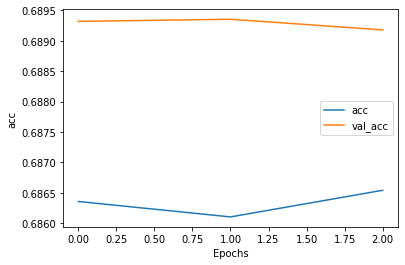

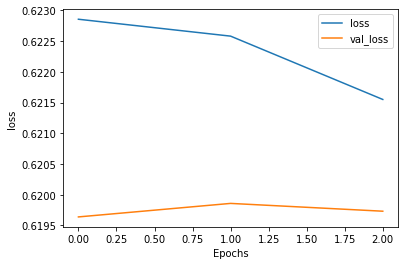

In [ ]:

# 결과 플롯
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, 'acc')

plot_graphs(history, 'loss')


### TEST

Test용

In [ ]:
# 위에 테스트~~ 어쩌구 거쳐서 만들기.

# # 테스트 데이터 불러오기
# DATA_OUT_PATH = './data_out/'
# TEST_INPUT_DATA = 'test_input.npy'
# TEST_ID_DATA = 'test_id.npy'

# test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
# test_input = pad_sequences(test_input, maxlen=test_input.shape[1])
# # id는 피클로
# with open(DATA_IN_PATH + TEST_ID_DATA, 'rb') as fw:
#   test_id = pickle.load(fw)

# 베스트 모델 불러오기
SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join('/gdrive/MyDrive/movie_predict/Sentiment Analysis/data_out/RNN/weights.h5'))


In [ ]:
review.reset_index(inplace = True)
review['id'] = review['index']
# 테스트 데이터 예측하기
predictions = model.predict(X_test, batch_size=512)
predictions = predictions.squeeze(-1)

# test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)
# if not os.path.exists(DATA_OUT_PATH):
#     os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={"id": list(review['id']), "sentiment": list(predictions)} )
output
# output.to_csv(DATA_OUT_PATH + 'movie_review_result_cnn.csv', index=False, quoting=3)


,id,sentiment
0,180,0.700401
1,181,0.700401
2,182,0.700401
3,183,0.700401
4,184,0.700401
...,...,...
35403,177868,0.700401
35404,177869,0.700401
35405,177870,0.700401
35406,178083,0.700401


<function posix.chdir>

In [ ]:
DATA_OUT_PATH = './data_out/'
srnn = pd.read_csv(DATA_OUT_PATH + 'movie_review_result_cnn.csv')
srnn

FileNotFoundError: ignored

In [ ]:
output['sentiment'].unique()

array([0.70040071, 0.70040065, 0.70873123, ..., 0.70193785, 0.77363026,
       0.68318492])

In [ ]:
temp = pd.merge(output,review,on = 'id', how = 'right')
review = temp

In [ ]:
review['RNN'] = review['sentiment_x']
review['sentiment'] = review['sentiment_y']
# temp_pred = review[['Movie_code','CNN','sentiment']] #예측 성능 확인용
review['pred'] = review['RNN'] > 0.5
review['pred'] = review['pred'].apply(lambda x: int(x))

review

In [ ]:
with open('rnn_pred_ans', 'wb') as fw:
  pickle.dump(review,fw)
## 일단 저장 여기까지. 각 test 영화별 평점 나온거. 
# 날짜 추가하기 여기에.

# 다시 로딩
with open('rnn_pred_ans', 'rb') as fr:
  review = pickle.load(fr)
review.head()

In [ ]:
review['sentiment'] = review['sentiment'].apply(lambda x: int(x))
review['pred'] = review['pred'].apply(lambda x: int(x))

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, plot_confusion_matrix
from sklearn.metrics import recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test=None, pred=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
# test에 대한 평가
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, plot_confusion_matrix
from sklearn.metrics import recall_score, f1_score, roc_auc_score


y_target = review['sentiment'].values
pred = review['pred'].values



get_clf_eval(y_target, pred)

# confusion = confusion_matrix(y_target, pred)
# print(confusion)
# print("정확도:", np.round(accuracy_score(y_target , pred),4))
# print("정밀도:", np.round(precision_score(y_target , pred),4))
# print("재현율:", np.round(recall_score(y_target, pred),4))

오차 행렬
[[    1 10896]
 [    3 24508]]
정확도: 0.6922, 정밀도: 0.6922, 재현율: 0.9999,    F1: 0.8181, AUC:0.5000


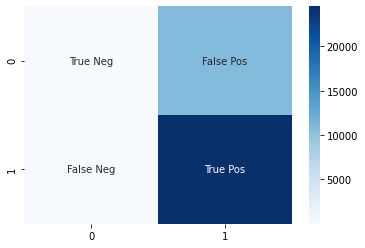

In [ ]:
# 시각화 
import seaborn as sns
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
confusion = confusion_matrix(y_target, pred)
sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')

### review에 감성점수 합치기

In [ ]:
# rnn_test = review[['id','RNN']]
rnn_test

,id,RNN
0,180,0.700401
1,181,0.700401
2,182,0.700401
3,183,0.700401
4,184,0.700401
...,...,...
35403,177868,0.700401
35404,177869,0.700401
35405,177870,0.700401
35406,178083,0.700401


In [ ]:
review.reset_index(inplace = True)
review['id'] = review['index']
review

In [ ]:
# test에 대한 값은 넣어짐.
# temp = pd.merge(review,rnn_test,how = 'left', on = 'id')
# temp
with open('rnn_review_test_score','wb') as fw:
  pickle.dump(temp,fw)
with open('rnn_review_test_score','rb') as fr:
  temp = pickle.load(fr)
#train도 넣기
# pd.merge(temp,rnn_train,how = 'left', on = 'id') 아래 표기


In [ ]:
# Train 넣는 과정.
# 테스트 데이터 예측하기
predictions = model.predict(X_train, batch_size=512)
predictions = predictions.squeeze(-1)

# test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)
# if not os.path.exists(DATA_OUT_PATH):
#     os.makedirs(DATA_OUT_PATH)
review.reset_index(inplace = True)
review['id'] = review['index']
output = pd.DataFrame(data={"id": list(review['id']), "sentiment": list(predictions)} )
output
# output.to_csv(DATA_OUT_PATH + 'movie_review_result_cnn.csv', index=False, quoting=3)


In [ ]:
review

In [ ]:
output.columns = ['id','RNN']
rnn_train = output
t = pd.merge(temp,rnn_train,how = 'outer', on = 'id')
t

In [ ]:
t = t.replace(np.nan,0)
t['RNN'] = t['RNN_x'] + t['RNN_y']
t

In [ ]:
t = t.replace(0,np.nan)
t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178076 entries, 0 to 178075
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   index          178075 non-null  float64       
 1   header         178076 non-null  object        
 2   date           178076 non-null  datetime64[ns]
 3   contents       178073 non-null  object        
 4   star           178076 non-null  float64       
 5   helpful        178076 non-null  object        
 6   released_date  178076 non-null  datetime64[ns]
 7   1_week_later   178076 non-null  datetime64[ns]
 8   2_weeks_later  178076 non-null  datetime64[ns]
 9   3_weeks_later  178076 non-null  datetime64[ns]
 10  4_weeks_later  178076 non-null  datetime64[ns]
 11  in_n_weeks     147103 non-null  object        
 12  Movie_code     178076 non-null  object        
 13  sentiment      122541 non-null  float64       
 14  id             178075 non-null  float64       
 15  

In [ ]:
# 기존 df에 추가를 위해 저-장
SA_model = 'RNN'
df = review[['Movie_code',SA_model]]
path = '/gdrive/MyDrive/movie_predict/DF/'+ SA_model
with open(path,'wb') as fw:
  pickle.dump(df,fw)


In [ ]:

# 저장확인
with open(path,'rb') as fr:
  test = pickle.load(fr)
test

## 4.CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os
import json

#랜덤 시드 고정
SEED_NUM = 0
tf.random.set_seed(SEED_NUM)

In [ ]:
# 모델 하이퍼파라미터 정의
model_name = 'cnn_classifier_en'
BATCH_SIZE = 512
NUM_EPOCHS = 4
VALID_SPLIT = 0.1
MAX_LEN = train_inputs.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_size': 128,
        'num_filters': 100,
        'dropout_rate': 0.5,
        'hidden_dimension': 250,
        'output_dimension':1}


In [ ]:

# 모델 선언 및 컴파일
class CNNClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation=tf.keras.activations.relu,
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                     for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                           activation=tf.keras.activations.relu,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x
    

model = CNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])


In [ ]:
train_inputs = np.asarray(train_inputs).astype('float32')
train_inputs.shape

(142670, 512)

In [ ]:
target_data = np.asarray(target_data).astype('float32')
target_data

array([1., 1., 1., ..., 1., 0., 1.], dtype=float32)

In [ ]:

# Callback 선언
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 모델 학습
history = model.fit(train_inputs, target_data, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])


./data_out/cnn_classifier_en -- Folder already exists 

Epoch 1/4


KeyboardInterrupt: ignored

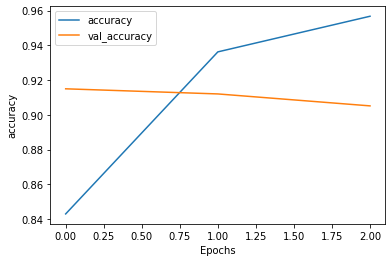

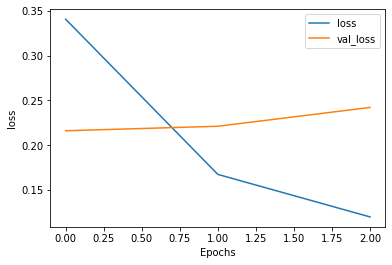

In [ ]:

# 결과 플롯

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, 'accuracy')

plot_graphs(history, 'loss')


다녀와서 test data 전처리 진행. model이 저장되어있으니.. 활용. test data에 train처럼 label 명시

In [ ]:
# 원래 코드
# # 테스트 데이터 불러오기
# DATA_OUT_PATH = './data_out/'
# TEST_INPUT_DATA = 'test_input.npy'
# TEST_ID_DATA = 'test_id.npy'

# test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
# test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

# 바꾼 코드
# df test 데이터를 예측

#####코드######

### TEST

In [ ]:
# 테스트 데이터 불러오기
DATA_OUT_PATH = './data_out/'
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'

test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])
# id는 피클로
with open(DATA_IN_PATH + TEST_ID_DATA, 'rb') as fw:
  test_id = pickle.load(fw)

# 베스트 모델 불러오기
SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))


In [ ]:
# 테스트 데이터 예측하기
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

# test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={"id": list(test_id), "sentiment": list(predictions)} )
output
# output.to_csv(DATA_OUT_PATH + 'movie_review_result_cnn.csv', index=False, quoting=3)


,id,sentiment
0,1284,0.763999
1,1285,0.521747
2,1286,0.734482
3,1287,0.922098
4,1288,0.994020
...,...,...
35403,1361991,0.014616
35404,1361994,0.918378
35405,1361995,0.021126
35406,1363408,0.997947


In [ ]:
review['id'] = review['index']

In [ ]:
# movie_code랑 합치기
# review - index test - id 를 기준으로 
temp = pd.merge(output,review,on = 'id', how = 'right')
review = temp

In [ ]:
review['CNN'] = review['sentiment_x']
review['sentiment'] = review['sentiment_y']
# temp_pred = review[['Movie_code','CNN','sentiment']] #예측 성능 확인용
review['pred'] = review['CNN'] > 0.5
review['pred'] = review['pred'].apply(lambda x: int(x))

review

In [ ]:

# with open('cnn_pred_ans', 'wb') as fw:
#   pickle.dump(review,fw)
## 일단 저장 여기까지. 각 test 영화별 평점 나온거. 
# 날짜 추가하기 여기에.

# 다시 로딩
with open('cnn_pred_ans', 'rb') as fr:
  review = pickle.load(fr)
review.head()

,id,sentiment_x,index,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,3_weeks_later,4_weeks_later,in_n_weeks,Movie_code,sentiment_y,CNN,sentiment,pred
0,1284,0.763999,1284,Stressed out\n,2006-02-06,"No wonder Charlie, the man at the center of th...",0.7,['28 out of 33'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,0.763999,1,1
1,1285,0.521747,1285,Brilliant but poor marketing...\n,2004-05-02,"This gem hit box offices in 2000, though there...",1.0,['32 out of 41'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,0.521747,1,1
2,1286,0.734482,1286,great sublime satire...\n,2001-02-21,what is wrong with this film? absolutely nothi...,0.7,['25 out of 34'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,0.734482,1,1
3,1287,0.922098,1287,And You Thought You Had It Tough?\n,2002-04-11,"Stress. It comes in many shapes and sizes, to ...",0.8,['17 out of 25'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,0.922098,1,1
4,1288,0.994020,1288,"Within the great adversities of life, this fl...",2006-08-05,"Gun Shy is apt title! This underrated comedy, ...",0.8,['17 out of 26'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,0.994020,1,1


In [ ]:
# cnn 컬럼만 추리기
cnn = review[['in_n_weeks','Movie_code','pred']]
cnn['cnn'] = cnn['pred']
cnn

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,in_n_weeks,Movie_code,pred,cnn
0,after 4 weeks,0171356,1,1
1,after 4 weeks,0171356,1,1
2,after 4 weeks,0171356,1,1
3,after 4 weeks,0171356,1,1
4,after 4 weeks,0171356,1,1
...,...,...,...,...
35403,after 4 weeks,1966359,0,0
35404,after 4 weeks,1966359,1,1
35405,2,1966359,0,0
35406,after 4 weeks,3630918,1,1


In [ ]:
review['sentiment'] = review['sentiment'].apply(lambda x: int(x))
review['pred'] = review['pred'].apply(lambda x: int(x))

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, plot_confusion_matrix
from sklearn.metrics import recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test=None, pred=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
# test에 대한 평가
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, plot_confusion_matrix
from sklearn.metrics import recall_score, f1_score, roc_auc_score


y_target = review['sentiment'].values
pred = review['pred'].values



get_clf_eval(y_target, pred)

# confusion = confusion_matrix(y_target, pred)
# print(confusion)
# print("정확도:", np.round(accuracy_score(y_target , pred),4))
# print("정밀도:", np.round(precision_score(y_target , pred),4))
# print("재현율:", np.round(recall_score(y_target, pred),4))

오차 행렬
[[ 9742  1155]
 [ 2085 22426]]
정확도: 0.9085, 정밀도: 0.9510, 재현율: 0.9149,    F1: 0.9326, AUC:0.9045


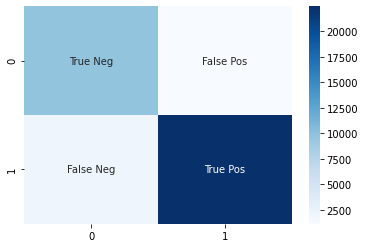

In [ ]:
# 시각화 
import seaborn as sns
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')

# 여기부터. 주차 별 sentiment 점수 만들기.

감성분석기 training은 Ticket 예측모델 Train data로만.

감성분석기 test는 Ticket 예측모델 Test data로만.

데이터 넘겨줄 때는 Training 한 모델로 
Whole data에 적용

In [ ]:
import os
os.chdir('/gdrive/MyDrive/movie_predict/Sentiment Analysis')
with open('cnn_pred_ans', 'rb') as fr:
  review = pickle.load(fr)
review.head()
# sentiment 가 답, pred가 cnn predict

,id,sentiment_x,index,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,3_weeks_later,4_weeks_later,in_n_weeks,Movie_code,sentiment_y,CNN,sentiment,pred
0,1284,0.763999,1284,Stressed out\n,2006-02-06,"No wonder Charlie, the man at the center of th...",0.7,['28 out of 33'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,0.763999,1,1
1,1285,0.521747,1285,Brilliant but poor marketing...\n,2004-05-02,"This gem hit box offices in 2000, though there...",1.0,['32 out of 41'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,0.521747,1,1
2,1286,0.734482,1286,great sublime satire...\n,2001-02-21,what is wrong with this film? absolutely nothi...,0.7,['25 out of 34'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,0.734482,1,1
3,1287,0.922098,1287,And You Thought You Had It Tough?\n,2002-04-11,"Stress. It comes in many shapes and sizes, to ...",0.8,['17 out of 25'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,0.922098,1,1
4,1288,0.994020,1288,"Within the great adversities of life, this fl...",2006-08-05,"Gun Shy is apt title! This underrated comedy, ...",0.8,['17 out of 26'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,0.994020,1,1


In [ ]:
review.shape

(35408, 19)

In [ ]:
# 기존 df에 추가를 위해 저-장
SA_model = 'CNN'
df = review[['Movie_code',SA_model]]
path = '/gdrive/MyDrive/movie_predict/DF/'+ SA_model
with open(path,'wb') as fw:
  pickle.dump(df,fw)


In [ ]:
# 저장확인
with open(path,'rb') as fr:
  test = pickle.load(fr)
test

,Movie_code,CNN
0,0195945,0.960963
1,0195945,0.990890
2,0195945,0.994928
3,0195945,0.999638
4,0195945,0.998094
...,...,...
178071,5974388,0.970234
178072,5974388,0.009105
178073,5974388,0.997154
178074,3630918,0.999993


# 5.LSTM

In [ ]:
import re
import json
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
import os
os.chdir('/gdrive/MyDrive/movie_predict/Sentiment Analysis')
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
# from tensorflow.keras.layers import Dense,LSTM,Embedding
#랜덤 시드 고정
SEED_NUM = 0
tf.random.set_seed(SEED_NUM)

In [ ]:
그냥 RNN에서 쓴 Preprocessing 쓰기 아래 이미 preprocessed 된셀..
# review['contents'] = review['contents'].apply(lambda x: str(x))
# from nltk.stem import WordNetLemmatizer
# def preprocessing(text):   #Preprocessing
#     # tokenize into words
#     tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)] 
   
#     # remove stopwords
#     stop = stopwords.words('english')
#     tokens = [token for token in tokens if token not in stop]
    
#     # remove words less than three letters
#     tokens = [word for word in tokens if len(word) >= 3]
    
#     # lower capitalization
#     tokens = [word.lower() for word in tokens]
    
#     # lemmatize
#     lmtzr = WordNetLemmatizer()
#     tokens = [lmtzr.lemmatize(word) for word in tokens]

#     preprocessed_text= ' '.join(tokens)
#     return preprocessed_text

# review['review_pre']=review['contents'].apply(lambda x: preprocessing(x))

In [ ]:

#미리 preprocessing함.
# review.to_csv('RNN_preprocessed_train.csv')
review = pd.read_csv('RNN_preprocessed_train.csv', index_col = 'Unnamed: 0')
review

review['review_pre'] = review['review_pre'].apply(lambda x : str(x))
# x, y 분리
X_data = review['review_pre']
y_data = review['sentiment']


In [ ]:

# 케라스 토크나이저를 이용한 토큰화와 정수 인코딩

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data) 
sequences = tokenizer.texts_to_sequences(X_data)

#패딩

MAX_SEQUENCE_LENGTH = 512
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print('Shape of train data: ', data.shape)

# 훈련 데이터와 테스트 데이터 분리 --> 따로 안해도 될듯. 타입만 잘 바꿔줘도 ㄱㅊ할듯.

X_train = data #
y_train = np.array(y_data) #


X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')


Shape of train data:  (142670, 512)


In [ ]:
model_name = "LSTM"
DATA_OUT_PATH = './data_out/'
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1  # 패딩을 위한 토큰인 0번 고려

In [ ]:
##
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callback 선언
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_acc', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True)


model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32 # Keras에서 Embedding 하려면, 먼저 정수 인코딩이 되어야 함
model.add(LSTM(64, activation = 'tanh')) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[earlystop_callback, cp_callback])



 567/1784 [========>.....................] - ETA: 31s - loss: 0.6197 - acc: 0.6891

KeyboardInterrupt: ignored

# TEST

In [ ]:

#미리 preprocessing함.
# review.to_csv('RNN_preprocessed_test.csv')
review = pd.read_csv('RNN_preprocessed_test.csv', index_col = 'Unnamed: 0')
review

In [ ]:
review['review_pre'] = review['review_pre'].apply(lambda x : str(x))
# x, y 분리
X_data = review['review_pre']
y_data = review['sentiment']

#texts_to_sequences
sequences = tokenizer.texts_to_sequences(X_data)

#패딩

MAX_SEQUENCE_LENGTH = 512
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print('Shape of train data: ', data.shape)

X_test = data
y_test = np.array(y_data)

X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')


Shape of train data:  (35408, 512)


In [ ]:
# 위에 테스트~~ 어쩌구 거쳐서 만들기.

# # 테스트 데이터 불러오기
# DATA_OUT_PATH = './data_out/'
# TEST_INPUT_DATA = 'test_input.npy'
# TEST_ID_DATA = 'test_id.npy'

# test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
# test_input = pad_sequences(test_input, maxlen=test_input.shape[1])
# # id는 피클로
# with open(DATA_IN_PATH + TEST_ID_DATA, 'rb') as fw:
#   test_id = pickle.load(fw)

# 베스트 모델 불러오기
SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join(checkpoint_path))


In [ ]:
review.reset_index(inplace = True)
review['id'] = review['index']
# 테스트 데이터 예측하기
predictions = model.predict(X_test, batch_size=512)
predictions = predictions.squeeze(-1)

# test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)
# if not os.path.exists(DATA_OUT_PATH):
#     os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={"id": list(review['id']), "sentiment": list(predictions)} )
output
# output.to_csv(DATA_OUT_PATH + 'movie_review_result_cnn.csv', index=False, quoting=3)


,id,sentiment
0,180,0.686252
1,181,0.686252
2,182,0.686252
3,183,0.686252
4,184,0.686252
...,...,...
35403,177868,0.686252
35404,177869,0.686252
35405,177870,0.686252
35406,178083,0.686252


In [ ]:
val_counts = output['sentiment'].value_counts()
val_counts = val_counts.sort_index()
val_counts

0.660454    1
0.662190    1
0.663611    1
0.665386    1
0.665503    1
           ..
0.777508    1
0.778759    1
0.780454    1
0.781593    1
0.783075    1
Name: sentiment, Length: 450, dtype: int64

In [ ]:
val_counts = pd.DataFrame(data = sorted_val, columns = ['sentiment','counts'])
val_counts['count'] = val_counts['sentiment']
val_counts.reset_index(inplace = True)

In [ ]:
val_counts['sentiment'] = val_counts['index']
val_counts.drop(['index','counts'],axis = 1, inplace = True)

val_counts

,sentiment,count
0,0.660454,1
1,0.662190,1
2,0.663611,1
3,0.665386,1
4,0.665503,1
...,...,...
445,0.777508,1
446,0.778759,1
447,0.780454,1
448,0.781593,1


In [ ]:
review.reset_index(inplace = True)
review['id'] = review['index']
# 테스트 데이터 예측하기
predictions = model.predict(X_test, batch_size=512)
predictions = predictions.squeeze(-1)

# test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)
# if not os.path.exists(DATA_OUT_PATH):
#     os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={"id": list(review['id']), "sentiment": list(predictions)} )
output
# output.to_csv(DATA_OUT_PATH + 'movie_review_result_cnn.csv', index=False, quoting=3)


,id,sentiment
0,180,0.686252
1,181,0.686252
2,182,0.686252
3,183,0.686252
4,184,0.686252
...,...,...
35403,177868,0.686252
35404,177869,0.686252
35405,177870,0.686252
35406,178083,0.686252


In [ ]:
temp = pd.merge(output,review,on = 'id', how = 'right')
review = temp
review['LSTM'] = review['sentiment_x']
review['sentiment'] = review['sentiment_y']
# temp_pred = review[['Movie_code','CNN','sentiment']] #예측 성능 확인용
review['pred'] = review['LSTM'] > 0.67
review['pred'] = review['pred'].apply(lambda x: int(x))

review

In [ ]:
# with open('rnn_pred_ans', 'wb') as fw:
#   pickle.dump(review,fw)
## 일단 저장 여기까지. 각 test 영화별 평점 나온거. 
# 날짜 추가하기 여기에.

# 다시 로딩
with open('rnn_pred_ans', 'rb') as fr:
  review = pickle.load(fr)
review.head()

review['sentiment'] = review['sentiment'].apply(lambda x: int(x))
review['pred'] = review['pred'].apply(lambda x: int(x))

In [ ]:
lstm = review[['in_n_weeks','Movie_code','RNN']]
lstm['lstm'] = lstm['RNN']
lstm

In [ ]:
lstm['lstm'].value_counts()

0.700401    26839
0.700401     3126
0.700401     3025
0.700401      128
0.700401      125
            ...  
0.700430        1
0.700429        1
0.700435        1
0.700433        1
0.700563        1
Name: lstm, Length: 1355, dtype: int64

In [ ]:
lstm

,in_n_weeks,Movie_code,RNN,lstm
0,after 4 weeks,0171356,0.700401,0.700401
1,after 4 weeks,0171356,0.700401,0.700401
2,after 4 weeks,0171356,0.700401,0.700401
3,after 4 weeks,0171356,0.700401,0.700401
4,after 4 weeks,0171356,0.700401,0.700401
...,...,...,...,...
35403,after 4 weeks,1966359,0.700401,0.700401
35404,after 4 weeks,1966359,0.700401,0.700401
35405,2,1966359,0.700401,0.700401
35406,after 4 weeks,3630918,0.700401,0.700401


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, plot_confusion_matrix
from sklearn.metrics import recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test=None, pred=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
# test에 대한 평가
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, plot_confusion_matrix
from sklearn.metrics import recall_score, f1_score, roc_auc_score


y_target = review['sentiment'].values
pred = review['pred'].values



get_clf_eval(y_target, pred)

# confusion = confusion_matrix(y_target, pred)
# print(confusion)
# print("정확도:", np.round(accuracy_score(y_target , pred),4))
# print("정밀도:", np.round(precision_score(y_target , pred),4))
# print("재현율:", np.round(recall_score(y_target, pred),4))

오차 행렬
[[    7 10890]
 [   10 24501]]
정확도: 0.6922, 정밀도: 0.6923, 재현율: 0.9996,    F1: 0.8180, AUC:0.5001


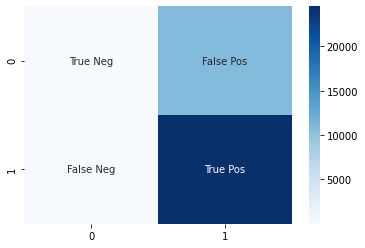

In [ ]:
# 시각화 
import seaborn as sns
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
confusion = confusion_matrix(y_target, pred)
sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')

# 6.GRU

LSTM 과정 따라가기.

In [ ]:
import re
import json
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
import os
os.chdir('/gdrive/MyDrive/movie_predict/Sentiment Analysis')
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
# from tensorflow.keras.layers import Dense,LSTM,Embedding
#랜덤 시드 고정
SEED_NUM = 0
tf.random.set_seed(SEED_NUM)

In [ ]:
그냥 RNN에서 쓴 Preprocessing 쓰기
# review['contents'] = review['contents'].apply(lambda x: str(x))
# from nltk.stem import WordNetLemmatizer
# def preprocessing(text):   #Preprocessing
#     # tokenize into words
#     tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)] 
   
#     # remove stopwords
#     stop = stopwords.words('english')
#     tokens = [token for token in tokens if token not in stop]
    
#     # remove words less than three letters
#     tokens = [word for word in tokens if len(word) >= 3]
    
#     # lower capitalization
#     tokens = [word.lower() for word in tokens]
    
#     # lemmatize
#     lmtzr = WordNetLemmatizer()
#     tokens = [lmtzr.lemmatize(word) for word in tokens]

#     preprocessed_text= ' '.join(tokens)
#     return preprocessed_text

# review['review_pre']=review['contents'].apply(lambda x: preprocessing(x))

In [ ]:

#미리 preprocessing함.
# review.to_csv('RNN_preprocessed_train.csv')
review = pd.read_csv('RNN_preprocessed_train.csv', index_col = 'Unnamed: 0')
review

review['review_pre'] = review['review_pre'].apply(lambda x : str(x))
# x, y 분리
X_data = review['review_pre']
y_data = review['sentiment']


In [ ]:

# 케라스 토크나이저를 이용한 토큰화와 정수 인코딩

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data) 
sequences = tokenizer.texts_to_sequences(X_data)

#패딩

MAX_SEQUENCE_LENGTH = 512
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print('Shape of train data: ', data.shape)

# 훈련 데이터와 테스트 데이터 분리 --> 따로 안해도 될듯. 타입만 잘 바꿔줘도 ㄱㅊ할듯.

X_train = data #
y_train = np.array(y_data) #


X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')


Shape of train data:  (142670, 512)


In [ ]:
model_name = "GRU"
DATA_OUT_PATH = './data_out/'
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1  # 패딩을 위한 토큰인 0번 고려

In [ ]:
##

from tensorflow.keras.layers import GRU, Embedding, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callback 선언
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_acc', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\


DATA_OUT_PATH = './data_out/'
TEST_INPUT_DATA = 'whole_input.npy'
TEST_ID_DATA = 'whole_id.npy'
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True)


model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32 # Keras에서 Embedding 하려면, 먼저 정수 인코딩이 되어야 함
model.add(GRU(100, activation = 'tanh')) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[earlystop_callback, cp_callback])



./data_out/GRU -- Folder already exists 

Epoch 1/10
1784/1784 [==============================] - 66s 36ms/step - loss: 0.6231 - acc: 0.6866 - val_loss: 0.6196 - val_acc: 0.6893

Epoch 00001: val_acc improved from -inf to 0.68932, saving model to ./data_out/GRU/weights.h5
Epoch 2/10
1784/1784 [==============================] - 63s 35ms/step - loss: 0.6223 - acc: 0.6866 - val_loss: 0.6199 - val_acc: 0.6893

Epoch 00002: val_acc did not improve from 0.68932
Epoch 3/10
1784/1784 [==============================] - 63s 35ms/step - loss: 0.3029 - acc: 0.8686 - val_loss: 0.2405 - val_acc: 0.9069

Epoch 00003: val_acc improved from 0.68932 to 0.90688, saving model to ./data_out/GRU/weights.h5
Epoch 4/10
1784/1784 [==============================] - 63s 35ms/step - loss: 0.1590 - acc: 0.9386 - val_loss: 0.2007 - val_acc: 0.9239

Epoch 00004: val_acc improved from 0.90688 to 0.92392, saving model to ./data_out/GRU/weights.h5
Epoch 5/10
1784/1784 [==============================] - 63s 35ms/step - 

#TEST

In [ ]:

#미리 preprocessing함.
# review.to_csv('RNN_preprocessed_test.csv')
review = pd.read_csv('RNN_preprocessed_test.csv', index_col = 'Unnamed: 0')

review['review_pre'] = review['review_pre'].apply(lambda x : str(x))
# x, y 분리
X_data = review['review_pre']
y_data = review['sentiment']

#texts_to_sequences
sequences = tokenizer.texts_to_sequences(X_data)

#패딩

MAX_SEQUENCE_LENGTH = 512
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print('Shape of train data: ', data.shape)

X_test = data
y_test = np.array(y_data)

X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

Shape of train data:  (35408, 512)


In [ ]:
# 위에 테스트~~ 어쩌구 거쳐서 만들기.

# # 테스트 데이터 불러오기
# DATA_OUT_PATH = './data_out/'
# TEST_INPUT_DATA = 'test_input.npy'
# TEST_ID_DATA = 'test_id.npy'

# test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
# test_input = pad_sequences(test_input, maxlen=test_input.shape[1])
# # id는 피클로
# with open(DATA_IN_PATH + TEST_ID_DATA, 'rb') as fw:
#   test_id = pickle.load(fw)

# 베스트 모델 불러오기
SAVE_FILE_NM = 'weights.h5'

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)
model.load_weights(os.path.join(checkpoint_path))


In [ ]:
review.reset_index(inplace = True)
review['id'] = review['index']
# 테스트 데이터 예측하기
predictions = model.predict(X_test, batch_size=512)
predictions = predictions.squeeze(-1)

# test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)
# if not os.path.exists(DATA_OUT_PATH):
#     os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={"id": list(review['id']), "sentiment": list(predictions)} )
output
# output.to_csv(DATA_OUT_PATH + 'movie_review_result_cnn.csv', index=False, quoting=3)


,id,sentiment
0,180,0.989671
1,181,0.997294
2,182,0.985910
3,183,0.991574
4,184,0.998959
...,...,...
35403,177868,0.003067
35404,177869,0.943221
35405,177870,0.001837
35406,178083,0.996706


In [ ]:
temp = pd.merge(output,review,on = 'id', how = 'right')
review = temp
review['GRU'] = review['sentiment_x']
review['sentiment'] = review['sentiment_y']
# temp_pred = review[['Movie_code','CNN','sentiment']] #예측 성능 확인용
review['pred'] = review['GRU'] > 0.5
review['pred'] = review['pred'].apply(lambda x: int(x))

review

In [ ]:
# with open('gru_pred_ans', 'wb') as fw:
#   pickle.dump(review,fw)
## 일단 저장 여기까지. 각 test 영화별 평점 나온거. 
# 날짜 추가하기 여기에.

# 다시 로딩
with open('gru_pred_ans', 'rb') as fr:
  review = pickle.load(fr)
review.head()

review['sentiment'] = review['sentiment'].apply(lambda x: int(x))
review['pred'] = review['pred'].apply(lambda x: int(x))

In [ ]:
gru = review[['in_n_weeks',	'Movie_code','pred']]
gru

,in_n_weeks,Movie_code,pred
0,after 4 weeks,171356,1
1,after 4 weeks,171356,1
2,after 4 weeks,171356,1
3,after 4 weeks,171356,1
4,after 4 weeks,171356,1
...,...,...,...
35403,after 4 weeks,1966359,0
35404,after 4 weeks,1966359,1
35405,2,1966359,0
35406,after 4 weeks,3630918,1


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, plot_confusion_matrix
from sklearn.metrics import recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test=None, pred=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
# test에 대한 평가
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, plot_confusion_matrix
from sklearn.metrics import recall_score, f1_score, roc_auc_score


y_target = review['sentiment'].values
pred = review['pred'].values



get_clf_eval(y_target, pred)

# confusion = confusion_matrix(y_target, pred)
# print(confusion)
# print("정확도:", np.round(accuracy_score(y_target , pred),4))
# print("정밀도:", np.round(precision_score(y_target , pred),4))
# print("재현율:", np.round(recall_score(y_target, pred),4))

오차 행렬
[[ 9619  1278]
 [  957 23554]]
정확도: 0.9369, 정밀도: 0.9485, 재현율: 0.9610,    F1: 0.9547, AUC:0.9218


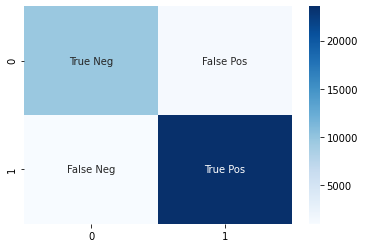

In [ ]:
# 시각화 
import seaborn as sns
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
confusion = confusion_matrix(y_target, pred)
sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')

# 7.BERT for ABSA

In [5]:
# train movie code 뽑아내기
import pickle
with open('/home/ibis/Min/movie predict/x_train_reviews','rb') as fr:
  review = pickle.load(fr)

review.reset_index(drop = True, inplace = True)
train_movie_code = list(review['Movie_code'].unique())
len(train_movie_code) # 6244


6244

In [6]:
# 전체 리뷰 
path = '/home/ibis/Min/movie predict/all_reviews'
with open(path,'rb') as fr:
  review = pickle.load(fr)
review

# contents가 nan 이면 제거하는 코드..써야함
review.dropna(axis = 0,inplace = True)
review.reset_index(drop = True, inplace = True)
print(review.shape)
review.head()


# 전처리 내용 담음.
review.reset_index(inplace = True)
review['id'] = review['index']
review

(178076, 13)


,index,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,3_weeks_later,4_weeks_later,in_n_weeks,Movie_code,sentiment,id
0,0,Actually quite funny without Chris Tucker\n,2002-03-16,Next Friday is actually pretty funny even thou...,1.0,['17 out of 25'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,0
1,1,Some good belly laughs\n,2000-04-11,It is not easy to sit through the whole movie ...,0.7,['4 out of 5'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,1
2,2,I loved that movie\n,2000-07-25,Next Friday is a movie i enjoyed to see all 4 ...,1.0,['5 out of 7'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,2
3,3,Worst of the trilogy but still pretty funny a...,2007-06-13,"Rated R for Language,Drug Use and Sexual Conte...",0.8,['8 out of 13'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,3
4,4,will there be another next time???\n,2001-03-02,"i hope so. friday part one, might been more fu...",0.8,['5 out of 10'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178071,178071,The Clash\n,2018-06-21,A study in tolerance and values as they clash ...,0.7,['3 out of 5'],2017-11-10,2017-11-17,2017-11-24,2017-12-01,2017-12-08,after 4 weeks,5974388,1,178071
178072,178072,"Tiresome Throwback To The 80's, We've All Mov...",2020-09-07,In BetweenThis movie had the feel of a student...,0.4,['1 out of 2'],2017-11-10,2017-11-17,2017-11-24,2017-12-01,2017-12-08,after 4 weeks,5974388,0,178072
178073,178073,An Intimate Slice of Three Palestinian Person...,2019-12-27,I love this film for three reasons: the cinema...,1.0,['1 out of 3'],2017-11-10,2017-11-17,2017-11-24,2017-12-01,2017-12-08,after 4 weeks,5974388,1,178073
178074,178074,Very Creepy Journey!!!\n,2020-03-21,This was one of those movies very well done. I...,0.8,['0 out of 1'],2017-09-29,2017-10-06,2017-10-13,2017-10-20,2017-10-27,after 4 weeks,3630918,1,178074


In [7]:
# # train_code와 Test_moviecode 분간하기. 

# #코드 잘 작동하나 예시
# dummy = review.loc[[0,62597],:] #train, test movie code.
# dummy_mc = list(dummy['Movie_code'])

# # review[review['Movie_code'] == '0841108'] #test code인 08-- 가 있는 리뷰 찾기.

# def is_train_movie_code(x):
#   if x in train_movie_code:
#     return 1
#   else:
#     return 0
# dummy['train'] = dummy.apply(lambda row: is_train_movie_code(row['Movie_code']),axis = 1)
# dummy

# # dummy 잘 작동.

In [8]:
def is_train_movie_code(x):
  if x in train_movie_code:
    return 1
  else:
    return 0
review['train'] = review.apply(lambda row: is_train_movie_code(row['Movie_code']),axis = 1)
review
# train, test 가 잘 표기됨.

,index,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,3_weeks_later,4_weeks_later,in_n_weeks,Movie_code,sentiment,id,train
0,0,Actually quite funny without Chris Tucker\n,2002-03-16,Next Friday is actually pretty funny even thou...,1.0,['17 out of 25'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,0,1
1,1,Some good belly laughs\n,2000-04-11,It is not easy to sit through the whole movie ...,0.7,['4 out of 5'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,1,1
2,2,I loved that movie\n,2000-07-25,Next Friday is a movie i enjoyed to see all 4 ...,1.0,['5 out of 7'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,2,1
3,3,Worst of the trilogy but still pretty funny a...,2007-06-13,"Rated R for Language,Drug Use and Sexual Conte...",0.8,['8 out of 13'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,3,1
4,4,will there be another next time???\n,2001-03-02,"i hope so. friday part one, might been more fu...",0.8,['5 out of 10'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178071,178071,The Clash\n,2018-06-21,A study in tolerance and values as they clash ...,0.7,['3 out of 5'],2017-11-10,2017-11-17,2017-11-24,2017-12-01,2017-12-08,after 4 weeks,5974388,1,178071,1
178072,178072,"Tiresome Throwback To The 80's, We've All Mov...",2020-09-07,In BetweenThis movie had the feel of a student...,0.4,['1 out of 2'],2017-11-10,2017-11-17,2017-11-24,2017-12-01,2017-12-08,after 4 weeks,5974388,0,178072,1
178073,178073,An Intimate Slice of Three Palestinian Person...,2019-12-27,I love this film for three reasons: the cinema...,1.0,['1 out of 3'],2017-11-10,2017-11-17,2017-11-24,2017-12-01,2017-12-08,after 4 weeks,5974388,1,178073,1
178074,178074,Very Creepy Journey!!!\n,2020-03-21,This was one of those movies very well done. I...,0.8,['0 out of 1'],2017-09-29,2017-10-06,2017-10-13,2017-10-20,2017-10-27,after 4 weeks,3630918,1,178074,0


## 1) 교수님 방법대로 절 --> 태깅 

### 리뷰를 문장으로 나누기.

In [4]:
# TweetTokenizer for messy, real world language. 
from nltk.tokenize import TweetTokenizer, sent_tokenize

input_text = "i loved it"
tokenizer_words = TweetTokenizer()
tokens_sentences = [tokenizer_words.tokenize(t) for t in 
nltk.sent_tokenize(input_text)]
print(tokens_sentences)

NameError: name 'nltk' is not defined

In [ ]:
#테스트용 문장 split

import nltk
# 테스트용 text
# text = review['contents'].loc[0] #복문 with 3sentences 잘됨.
# text = "kinda liked it" #단문 with 1 sentence. 잘됨.,
sent_text = nltk.sent_tokenize(text) # this gives us a list of sentences

# POS 태깅
# # now loop over each sentence and tokenize it separately
# for sentence in sent_text:
#     tokenized_text = nltk.word_tokenize(sentence)
#     tagged = nltk.pos_tag(tokenized_text)
#     print(tagged)

NameError: ignored

In [8]:
# # review 문장으로 split
# review['contents'] = review['contents'].apply(lambda x: str(x)) #str 아닌 에러.
# review['sents'] =  review['contents'].apply(lambda sents: nltk.sent_tokenize(sents))
# review

# # 체크포인트
# import pickle
# import os
# os.chdir('/gdrive/MyDrive/movie_predict/ABSA/preprocessing review')

# with open('review_contents_to_sents', 'wb') as fw:
#   pickle.dump(review,fw)

In [9]:
# 처리된 review load
import os
os.chdir('/gdrive/MyDrive/movie_predict/ABSA/preprocessing review')
with open('review_contents_to_sents', 'rb') as fr:
  review = pickle.load(fr)
review

FileNotFoundError: [Errno 2] No such file or directory: '/gdrive/MyDrive/movie_predict/ABSA/preprocessing review'

In [10]:
# doc id 부여
review['doc_id'] = review['id']
review.drop(['id','index'],axis = 1, inplace = True)
review

,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,3_weeks_later,4_weeks_later,in_n_weeks,Movie_code,sentiment,train,doc_id
0,Actually quite funny without Chris Tucker\n,2002-03-16,Next Friday is actually pretty funny even thou...,1.0,['17 out of 25'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,1,0
1,Some good belly laughs\n,2000-04-11,It is not easy to sit through the whole movie ...,0.7,['4 out of 5'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,1,1
2,I loved that movie\n,2000-07-25,Next Friday is a movie i enjoyed to see all 4 ...,1.0,['5 out of 7'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,1,2
3,Worst of the trilogy but still pretty funny a...,2007-06-13,"Rated R for Language,Drug Use and Sexual Conte...",0.8,['8 out of 13'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,1,3
4,will there be another next time???\n,2001-03-02,"i hope so. friday part one, might been more fu...",0.8,['5 out of 10'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178071,The Clash\n,2018-06-21,A study in tolerance and values as they clash ...,0.7,['3 out of 5'],2017-11-10,2017-11-17,2017-11-24,2017-12-01,2017-12-08,after 4 weeks,5974388,1,1,178071
178072,"Tiresome Throwback To The 80's, We've All Mov...",2020-09-07,In BetweenThis movie had the feel of a student...,0.4,['1 out of 2'],2017-11-10,2017-11-17,2017-11-24,2017-12-01,2017-12-08,after 4 weeks,5974388,0,1,178072
178073,An Intimate Slice of Three Palestinian Person...,2019-12-27,I love this film for three reasons: the cinema...,1.0,['1 out of 3'],2017-11-10,2017-11-17,2017-11-24,2017-12-01,2017-12-08,after 4 weeks,5974388,1,1,178073
178074,Very Creepy Journey!!!\n,2020-03-21,This was one of those movies very well done. I...,0.8,['0 out of 1'],2017-09-29,2017-10-06,2017-10-13,2017-10-20,2017-10-27,after 4 weeks,3630918,1,0,178074


In [ ]:
# review2 = review[30000:60000] # colab에서 돌려놓고 가기.
# review3 = review[60000:90000]
review4 = review[90000:120000]
review5 = review[120000:]
rv = review4

# 밑에 피클이름도 바꿔

In [5]:
# sents len 만큼 반복하며 sent 채워넣기
from tqdm import tqdm
tqdm.pandas()

review_sents = pd.DataFrame(data = [], columns = review.columns)
review_sents


#1) review_sents에 review 기본정보 sents 갯수만큼 추가
def fill_df(row):
  for i in range(len(row['sents'])):
    global review_sents
    #2) sents 배치
    sent = row['sents'][i]
    row['sent'] = sent
    review_sents = review_sents.append(row)
    
 

rv.progress_apply(lambda row: fill_df(row),axis = 1)
review_sents

NameError: name 'pd' is not defined

In [ ]:
# checkpoint
# with open('review2tosent','wb') as fw:
#     pickle.dump(review_sents,fw)
with open('review2tosent','rb') as fr:
    d = pickle.load(fr)
d
# with open('review_contents_to_sents_done', 'wb') as fw:
#   pickle.dump(review_sents,fw)

# import os
# os.chdir('/gdrive/MyDrive/movie_predict/ABSA/preprocessing review')
# with open('review_contents_to_sents_done', 'rb') as fr:
#   review = pickle.load(fr)
# review

In [ ]:
import os
os.chdir('/gdrive/MyDrive/movie_predict/ABSA/preprocessing review')
# with open('review2tosent','wb') as fw:
#     pickle.dump(review_sents,fw)
with open('review2tosent','rb') as fr:
    d = pickle.load(fr)
d

,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,3_weeks_later,4_weeks_later,in_n_weeks,Movie_code,sentiment,train,sents,doc_id,sent
30000,Up with this movie! It pays great homage to t...,2007-02-15,Barbara (Renee Zellweger) has just written a b...,0.7,['16 out of 22'],2003-05-16,2003-05-23,2003-05-30,2003-06-06,2003-06-13,after 4 weeks,0309530,1,1,[Barbara (Renee Zellweger) has just written a ...,30000,Barbara (Renee Zellweger) has just written a b...
30000,Up with this movie! It pays great homage to t...,2007-02-15,Barbara (Renee Zellweger) has just written a b...,0.7,['16 out of 22'],2003-05-16,2003-05-23,2003-05-30,2003-06-06,2003-06-13,after 4 weeks,0309530,1,1,[Barbara (Renee Zellweger) has just written a ...,30000,"She leaves Maine and lands in New York City, w..."
30000,Up with this movie! It pays great homage to t...,2007-02-15,Barbara (Renee Zellweger) has just written a b...,0.7,['16 out of 22'],2003-05-16,2003-05-23,2003-05-30,2003-06-06,2003-06-13,after 4 weeks,0309530,1,1,[Barbara (Renee Zellweger) has just written a ...,30000,"Unfortunately, the male executives at her publ..."
30000,Up with this movie! It pays great homage to t...,2007-02-15,Barbara (Renee Zellweger) has just written a b...,0.7,['16 out of 22'],2003-05-16,2003-05-23,2003-05-30,2003-06-06,2003-06-13,after 4 weeks,0309530,1,1,[Barbara (Renee Zellweger) has just written a ...,30000,"The lone woman at Banner publishing, Vicki, ta..."
30000,Up with this movie! It pays great homage to t...,2007-02-15,Barbara (Renee Zellweger) has just written a b...,0.7,['16 out of 22'],2003-05-16,2003-05-23,2003-05-30,2003-06-06,2003-06-13,after 4 weeks,0309530,1,1,[Barbara (Renee Zellweger) has just written a ...,30000,"First, they decide to ask Catcher Block (Ewan ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59999,"The way a musical should be, contemporary and...",2007-05-01,As I've posted previously I don't really like ...,0.9,['109 out of 140'],2007-06-15,2007-06-22,2007-06-29,2007-07-06,2007-07-13,0,0907657,1,1,[As I've posted previously I don't really like...,59999,I don't know the guy whatsoever but this is ab...
59999,"The way a musical should be, contemporary and...",2007-05-01,As I've posted previously I don't really like ...,0.9,['109 out of 140'],2007-06-15,2007-06-22,2007-06-29,2007-07-06,2007-07-13,0,0907657,1,1,[As I've posted previously I don't really like...,59999,I'd only been inside the cathedral once before...
59999,"The way a musical should be, contemporary and...",2007-05-01,As I've posted previously I don't really like ...,0.9,['109 out of 140'],2007-06-15,2007-06-22,2007-06-29,2007-07-06,2007-07-13,0,0907657,1,1,[As I've posted previously I don't really like...,59999,During the gig he gave a solo performance whic...
59999,"The way a musical should be, contemporary and...",2007-05-01,As I've posted previously I don't really like ...,0.9,['109 out of 140'],2007-06-15,2007-06-22,2007-06-29,2007-07-06,2007-07-13,0,0907657,1,1,[As I've posted previously I don't really like...,59999,I've seen A LOT of bands big and small so that...


In [ ]:
#@title 기본 제목 텍스트
d['sent'].iloc[5001]

"Not that I have something against gay people, it just that I hate this kind of movies.But, one man's garbage is another man's gold."

### 문장을 절로 나누기 --> 안함.

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
sentence = "He eats cheese, but he won't eat ice cream."
doc = nlp(sentence)
for token in doc:
    ancestors = [t.text for t in token.ancestors]
    children = [t.text for t in token.children]
    print(token.text, "\t", token.i, "\t", 
          token.pos_, "\t", token.dep_, "\t", 
          ancestors, "\t", children)

He 	 0 	 PRON 	 nsubj 	 ['eats'] 	 []
eats 	 1 	 VERB 	 ROOT 	 [] 	 ['He', 'cheese', ',', 'but', 'eat']
cheese 	 2 	 NOUN 	 dobj 	 ['eats'] 	 []
, 	 3 	 PUNCT 	 punct 	 ['eats'] 	 []
but 	 4 	 CCONJ 	 cc 	 ['eats'] 	 []
he 	 5 	 PRON 	 nsubj 	 ['eat', 'eats'] 	 []
wo 	 6 	 VERB 	 aux 	 ['eat', 'eats'] 	 []
n't 	 7 	 PART 	 neg 	 ['eat', 'eats'] 	 []
eat 	 8 	 VERB 	 conj 	 ['eats'] 	 ['he', 'wo', "n't", 'cream', '.']
ice 	 9 	 NOUN 	 compound 	 ['cream', 'eat', 'eats'] 	 []
cream 	 10 	 NOUN 	 dobj 	 ['eat', 'eats'] 	 ['ice']
. 	 11 	 PUNCT 	 punct 	 ['eat', 'eats'] 	 []


In [ ]:
def find_root_of_sentence(doc):
    root_token = None
    for token in doc:
        if (token.dep_ == "ROOT"):
            root_token = token
    return root_token
root_token = find_root_of_sentence(doc)

In [ ]:
def find_other_verbs(doc, root_token):
    other_verbs = []
    for token in doc: # doc가 spacy 객체되었으니 for문 돌리면 단어가 loop돔
        ancestors = list(token.ancestors)
        if (token.pos_ == "VERB" and len(ancestors) == 1\
            and ancestors[0] == root_token):
            other_verbs.append(token)
    return other_verbs
other_verbs = find_other_verbs(doc, root_token)

In [ ]:
def get_clause_token_span_for_verb(verb, doc, all_verbs):
    first_token_index = len(doc)
    last_token_index = 0
    this_verb_children = list(verb.children)
    for child in this_verb_children:
        if (child not in all_verbs):
            if (child.i < first_token_index):
                first_token_index = child.i
            if (child.i > last_token_index):
                last_token_index = child.i
    return(first_token_index, last_token_index)

token_spans = []   
all_verbs = [root_token] + other_verbs
for other_verb in all_verbs:
    (first_token_index, last_token_index) = \
     get_clause_token_span_for_verb(other_verb, 
                                    doc, all_verbs)
    token_spans.append((first_token_index, 
                        last_token_index))

In [ ]:
sentence_clauses = []
for token_span in token_spans:
    start = token_span[0]
    end = token_span[1]
    if (start < end):
        clause = doc[start:end]
        sentence_clauses.append(clause)
sentence_clauses = sorted(sentence_clauses, 
                          key=lambda tup: tup[0])

In [ ]:
clauses_text = [clause.text for clause in sentence_clauses]
print(clauses_text)

['He eats cheese,', "he won't eat ice cream"]


### EDA for max len 

In [185]:
with open('/home/ibis/Downloads/review_sent','rb') as fr:
    review = pickle.load(fr)
review

,level_0,index,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,3_weeks_later,4_weeks_later,in_n_weeks,Movie_code,sentiment,id,train,sents,doc_id,sent
0,0,NaN,Actually quite funny without Chris Tucker\n,2002-03-16,Next Friday is actually pretty funny even thou...,1.0,['17 out of 25'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,NaN,1,[Next Friday is actually pretty funny even tho...,0,Next Friday is actually pretty funny even thou...
1,0,NaN,Actually quite funny without Chris Tucker\n,2002-03-16,Next Friday is actually pretty funny even thou...,1.0,['17 out of 25'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,NaN,1,[Next Friday is actually pretty funny even tho...,0,Ice Cube makes a funny script with the help of...
2,0,NaN,Actually quite funny without Chris Tucker\n,2002-03-16,Next Friday is actually pretty funny even thou...,1.0,['17 out of 25'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,NaN,1,[Next Friday is actually pretty funny even tho...,0,All in all if you just want a good time check ...
3,1,NaN,Some good belly laughs\n,2000-04-11,It is not easy to sit through the whole movie ...,0.7,['4 out of 5'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,NaN,1,[It is not easy to sit through the whole movie...,1,It is not easy to sit through the whole movie ...
4,1,NaN,Some good belly laughs\n,2000-04-11,It is not easy to sit through the whole movie ...,0.7,['4 out of 5'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,NaN,1,[It is not easy to sit through the whole movie...,1,"However, there are some seriously funny things..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318309,139998,NaN,Not As Bad As People Say\n,2012-06-26,I sat in the theater and listened to people bo...,0.7,['3 out of 5'],2012-01-06,2012-01-13,2012-01-20,2012-01-27,2012-02-03,after 4 weeks,1560985,1,NaN,1,[I sat in the theater and listened to people b...,139998,"Also, it followed along more closely with actu..."
1318310,139998,NaN,Not As Bad As People Say\n,2012-06-26,I sat in the theater and listened to people bo...,0.7,['3 out of 5'],2012-01-06,2012-01-13,2012-01-20,2012-01-27,2012-02-03,after 4 weeks,1560985,1,NaN,1,[I sat in the theater and listened to people b...,139998,I would recommend watching it without high exp...
1318311,139999,NaN,good\n,2012-03-18,i watched this film/documentary and regardless...,1.0,['3 out of 5'],2012-01-06,2012-01-13,2012-01-20,2012-01-27,2012-02-03,after 4 weeks,1560985,1,NaN,1,[i watched this film/documentary and regardles...,139999,i watched this film/documentary and regardless...
1318312,139999,NaN,good\n,2012-03-18,i watched this film/documentary and regardless...,1.0,['3 out of 5'],2012-01-06,2012-01-13,2012-01-20,2012-01-27,2012-02-03,after 4 weeks,1560985,1,NaN,1,[i watched this film/documentary and regardles...,139999,"if you havet yet seen this i advise to see it,..."


In [197]:
from nltk.tokenize import word_tokenize
text = review['header'].loc[0]
print(word_tokenize(text))

['Actually', 'quite', 'funny', 'without', 'Chris', 'Tucker']


In [198]:

review['sent_tokenized'] = review['sent'].apply(lambda sent : word_tokenize(sent))

In [199]:
review['sent_tokenized_num'] = review['sent_tokenized'].apply(lambda sent: len(sent))

<AxesSubplot:>

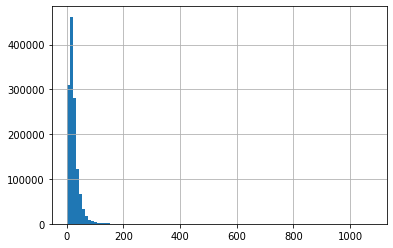

In [200]:
review['sent_tokenized_num'].hist(bins = 100)

### 모델 훈련

In [9]:
# sentence로 나눠진 df 
with open('/home/ibis/Downloads/review_sent','rb') as fr:
    review = pickle.load(fr)
review

,level_0,index,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,3_weeks_later,4_weeks_later,in_n_weeks,Movie_code,sentiment,id,train,sents,doc_id,sent
0,0,NaN,Actually quite funny without Chris Tucker\n,2002-03-16,Next Friday is actually pretty funny even thou...,1.0,['17 out of 25'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,NaN,1,[Next Friday is actually pretty funny even tho...,0,Next Friday is actually pretty funny even thou...
1,0,NaN,Actually quite funny without Chris Tucker\n,2002-03-16,Next Friday is actually pretty funny even thou...,1.0,['17 out of 25'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,NaN,1,[Next Friday is actually pretty funny even tho...,0,Ice Cube makes a funny script with the help of...
2,0,NaN,Actually quite funny without Chris Tucker\n,2002-03-16,Next Friday is actually pretty funny even thou...,1.0,['17 out of 25'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,NaN,1,[Next Friday is actually pretty funny even tho...,0,All in all if you just want a good time check ...
3,1,NaN,Some good belly laughs\n,2000-04-11,It is not easy to sit through the whole movie ...,0.7,['4 out of 5'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,NaN,1,[It is not easy to sit through the whole movie...,1,It is not easy to sit through the whole movie ...
4,1,NaN,Some good belly laughs\n,2000-04-11,It is not easy to sit through the whole movie ...,0.7,['4 out of 5'],2000-01-12,2000-01-19,2000-01-26,2000-02-02,2000-02-09,after 4 weeks,0195945,1,NaN,1,[It is not easy to sit through the whole movie...,1,"However, there are some seriously funny things..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318309,139998,NaN,Not As Bad As People Say\n,2012-06-26,I sat in the theater and listened to people bo...,0.7,['3 out of 5'],2012-01-06,2012-01-13,2012-01-20,2012-01-27,2012-02-03,after 4 weeks,1560985,1,NaN,1,[I sat in the theater and listened to people b...,139998,"Also, it followed along more closely with actu..."
1318310,139998,NaN,Not As Bad As People Say\n,2012-06-26,I sat in the theater and listened to people bo...,0.7,['3 out of 5'],2012-01-06,2012-01-13,2012-01-20,2012-01-27,2012-02-03,after 4 weeks,1560985,1,NaN,1,[I sat in the theater and listened to people b...,139998,I would recommend watching it without high exp...
1318311,139999,NaN,good\n,2012-03-18,i watched this film/documentary and regardless...,1.0,['3 out of 5'],2012-01-06,2012-01-13,2012-01-20,2012-01-27,2012-02-03,after 4 weeks,1560985,1,NaN,1,[i watched this film/documentary and regardles...,139999,i watched this film/documentary and regardless...
1318312,139999,NaN,good\n,2012-03-18,i watched this film/documentary and regardless...,1.0,['3 out of 5'],2012-01-06,2012-01-13,2012-01-20,2012-01-27,2012-02-03,after 4 weeks,1560985,1,NaN,1,[i watched this film/documentary and regardles...,139999,"if you havet yet seen this i advise to see it,..."


In [10]:
import os
import re
import numpy as np
from tqdm import tqdm

import tensorflow as tf
import transformers

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
# !pip install matplotlib
import matplotlib.pyplot as plt

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

ModuleNotFoundError: No module named 'transformers'

In [203]:
# for uncased 
def clean_text(sent):
  sent = str(sent)
  sent_lower = sent.lower() # lower case
  # sent_clean = re.sub("[^a-z]"," ", sent_lower) # re.sub(감지 할 정규표현식, 대체할 문자, input 텍스트) #only english
  # 지워지고 띄어쓰기가 3개씩 되어있는것도 있는데 ㄱㅊ하겠지? space로 대체 안하면 다 붙음
  # .을 지웠더니 tokenizing에 문제가 생길지? 확인. --> 앵무새책에서는 신경안씀.
  #stop words removal 은 제외. stop = stopwords.words('english')
  return sent_lower
# contents
review['clean_review'] = review['contents'].apply(lambda row: clean_text(row))
review['clean_review']

#header for uncased
review['clean_header'] = review['header'].apply(lambda row: clean_text(row))
review['clean_header']

#sent for uncased
review['clean_sent'] = review['sent'].apply(lambda row: clean_text(row))
review['clean_sent']


0          next friday is actually pretty funny even thou...
1          ice cube makes a funny script with the help of...
2          all in all if you just want a good time check ...
3          it is not easy to sit through the whole movie ...
4          however, there are some seriously funny things...
                                 ...                        
1318309    also, it followed along more closely with actu...
1318310    i would recommend watching it without high exp...
1318311    i watched this film/documentary and regardless...
1318312    if you havet yet seen this i advise to see it,...
1318313    enjoy the film and looking forward to reading ...
Name: clean_sent, Length: 1318314, dtype: object

In [204]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [205]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE =32#32는 너무 적소. 더 크게 조정하기.
NUM_EPOCHS = 5
VALID_SPLIT = 0.2
MAX_LEN = 32
DATA_IN_PATH = 'data_in/ENG'
DATA_OUT_PATH = "data_out/ENG"

In [206]:
# !pip install ipywidgets
bert_model = "bert-base-uncased"
# bert_model = "bert-base-cased"
# bert_model = 'bert-base-multilingual-cased'
tokenizer = transformers.BertTokenizer.from_pretrained(bert_model, cache_dir='bert_ckpt', do_lower_case=False) #bert-base-cased도 가능.
# https://huggingface.co/transformers/pretrained_models.html 에 large 도 등재.

In [207]:
# testing tokenizer
test_sentence = "I love this movie a lot. Thanks to  mr  campbell"

encode = tokenizer.encode(test_sentence)
token_print = [tokenizer.decode(token) for token in encode]

print(encode)
print(token_print)

[101, 100, 2293, 2023, 3185, 1037, 2843, 1012, 100, 2000, 2720, 6063, 102]
['[ C L S ]', '[ U N K ]', 'l o v e', 't h i s', 'm o v i e', 'a', 'l o t', '.', '[ U N K ]', 't o', 'm r', 'c a m p b e l l', '[ S E P ]']


In [208]:
eng_encode = tokenizer.encode("Hello world")
eng_decode = tokenizer.decode(eng_encode)


print(eng_encode)
# [101, 31178, 11356, 102]
print(eng_decode)
# [CLS] Hello world [SEP]

[101, 100, 2088, 102]
[CLS] [UNK] world [SEP]


In [209]:
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

In [210]:
# Use Train data only for fine-tuning
train_data = review[review['train'] == 1]# 실제 코드
# train_data = review[review['train'] == 1][:1000]# for test

input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in tqdm(zip(train_data["clean_sent"], train_data["sentiment"]), total=len(train_data)): #  ,uncased 용
# for train_sent, train_label in tqdm(zip(train_data['sent'], train_data["sentiment"]), total=len(train_data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_movie_input_ids = np.array(input_ids, dtype=int)
train_movie_attention_masks = np.array(attention_masks, dtype=int)
train_movie_type_ids = np.array(token_type_ids, dtype=int)
train_movie_inputs = (train_movie_input_ids, train_movie_attention_masks, train_movie_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("# sents: {}, # labels: {}".format(len(train_movie_input_ids), len(train_data_labels)))

  0%|                                               | 0/1060641 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/ibis/anaconda3/envs/py38tf2/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.war

# sents: 1060641, # labels: 1060641


In [211]:
train_movie_input_ids.shape

(1060641, 32)

In [212]:
input_id = train_movie_input_ids[200]
attention_mask = train_movie_attention_masks[200]
token_type_id = train_movie_type_ids[200]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[ 101 3038 2008 1010 1045 2036 2903 2008 1005 1055 1996 3114 2339 1045
 5632 2009 2061 2172 1012  102    0    0    0    0    0    0    0    0
    0    0    0    0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[CLS] saying that, i also believe that's the reason why i enjoyed it so much. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [213]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = transformers.TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)
        return logits

cls_model = TFBertClassifier(model_name=bert_model,
                                  dir_path='bert_ckpt',
                                  num_class=2)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [214]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [1]:
multiworker_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

NameError: name 'tf' is not defined

In [216]:
# model_name = "tf2_bert_imdb_trained"
model_name ="tf2_imdb_"+bert_model+'_maxlen'+str(MAX_LEN)+"_batch"+str(BATCH_SIZE)+"forsent"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_movie_inputs, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch

print(history.history)
#밑에 나타난 숫자는 그냥 batch에 따라 바뀐 숫자..

data_out/ENG/tf2_imdb_bert-base-uncased_maxlen32_batch32forsent -- Folder already exists 

Epoch 1/2
26516/26516 [==============================] - ETA: 0s - loss: 0.4050 - accuracy: 0.8145WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).

Epoch 00001: val_accuracy improved from -inf to 0.82893, saving model to data_out/ENG/tf2_imdb_bert-base-uncased_maxlen32_batch32forsent/weights.h5
26516/26516 [==============================] - 3822s 144ms/step - loss: 0.4050 - accuracy: 0.8145 - val_loss: 0.3869 - val_accuracy: 0.8289
Epoch 2/2
26516/26516 [==============================] - ETA: 0s - loss: 0.3343 - accuracy: 0.8526
Epoch 00002: val_accuracy improved from 0.82893 to 0.83504, saving model to data_out/ENG/tf2_imdb_bert-base-uncased_maxlen32_batch32forsent/weights.h5
26516/2651

#### test set

In [217]:
# 모델 weight 불러오는 법. (되나 확인)
bert_finetuned_path = 'data_out/ENG/'+model_name +'/weights.h5'
cls_model.load_weights(bert_finetuned_path)


In [218]:
test_data = review[review['train'] == 0] # 테스트 할당된 헤더로만 평가
test_data

,level_0,index,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,...,Movie_code,sentiment,id,train,sents,doc_id,sent,clean_review,clean_header,clean_sent
1928,180,NaN,Stressed out\n,2006-02-06,"No wonder Charlie, the man at the center of th...",0.7,['28 out of 33'],2000-02-04,2000-02-11,2000-02-18,...,0171356,1,NaN,0,"[No wonder Charlie, the man at the center of t...",180,"No wonder Charlie, the man at the center of th...","no wonder charlie, the man at the center of th...",stressed out\n,"no wonder charlie, the man at the center of th..."
1929,180,NaN,Stressed out\n,2006-02-06,"No wonder Charlie, the man at the center of th...",0.7,['28 out of 33'],2000-02-04,2000-02-11,2000-02-18,...,0171356,1,NaN,0,"[No wonder Charlie, the man at the center of t...",180,He has too many things to worry about and all ...,"no wonder charlie, the man at the center of th...",stressed out\n,he has too many things to worry about and all ...
1930,180,NaN,Stressed out\n,2006-02-06,"No wonder Charlie, the man at the center of th...",0.7,['28 out of 33'],2000-02-04,2000-02-11,2000-02-18,...,0171356,1,NaN,0,"[No wonder Charlie, the man at the center of t...",180,What's an undercover man to do?,"no wonder charlie, the man at the center of th...",stressed out\n,what's an undercover man to do?
1931,180,NaN,Stressed out\n,2006-02-06,"No wonder Charlie, the man at the center of th...",0.7,['28 out of 33'],2000-02-04,2000-02-11,2000-02-18,...,0171356,1,NaN,0,"[No wonder Charlie, the man at the center of t...",180,He gets involved more deeply into trying to do...,"no wonder charlie, the man at the center of th...",stressed out\n,he gets involved more deeply into trying to do...
1932,180,NaN,Stressed out\n,2006-02-06,"No wonder Charlie, the man at the center of th...",0.7,['28 out of 33'],2000-02-04,2000-02-11,2000-02-18,...,0171356,1,NaN,0,"[No wonder Charlie, the man at the center of t...",180,It deserved a better fate because of the funny...,"no wonder charlie, the man at the center of th...",stressed out\n,it deserved a better fate because of the funny...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317312,139912,NaN,Don't let the trailer fool you\n,2015-07-20,I watched the trailer years ago and only recen...,0.9,['2 out of 2'],2012-01-20,2012-01-27,2012-02-03,...,0477302,1,NaN,0,[I watched the trailer years ago and only rece...,139912,"So, although the general story-line was accura...",i watched the trailer years ago and only recen...,don't let the trailer fool you\n,"so, although the general story-line was accura..."
1317313,139912,NaN,Don't let the trailer fool you\n,2015-07-20,I watched the trailer years ago and only recen...,0.9,['2 out of 2'],2012-01-20,2012-01-27,2012-02-03,...,0477302,1,NaN,0,[I watched the trailer years ago and only rece...,139912,I still thoroughly enjoyed the film - I found ...,i watched the trailer years ago and only recen...,don't let the trailer fool you\n,i still thoroughly enjoyed the film - i found ...
1317314,139912,NaN,Don't let the trailer fool you\n,2015-07-20,I watched the trailer years ago and only recen...,0.9,['2 out of 2'],2012-01-20,2012-01-27,2012-02-03,...,0477302,1,NaN,0,[I watched the trailer years ago and only rece...,139912,Perhaps it was because I hadn't been expecting...,i watched the trailer years ago and only recen...,don't let the trailer fool you\n,perhaps it was because i hadn't been expecting...
1317315,139912,NaN,Don't let the trailer fool you\n,2015-07-20,I watched the trailer years ago and only recen...,0.9,['2 out of 2'],2012-01-20,2012-01-27,2012-02-03,...,0477302,1,NaN,0,[I watched the trailer years ago and only rece...,139912,"Overall, it was surprisingly different from wh...",i watched the trailer years ago and only recen...,don't let the trailer fool you\n,"overall, it was surprisingly different from wh..."


In [219]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sent, test_label in tqdm(zip(test_data["clean_header"], test_data["sentiment"])):
# for test_sent, test_label in tqdm(zip(test_data["header"], test_data["sentiment"])):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_movie_input_ids = np.array(input_ids, dtype=int)
test_movie_attention_masks = np.array(attention_masks, dtype=int)
test_movie_type_ids = np.array(token_type_ids, dtype=int)
test_movie_inputs = (test_movie_input_ids, test_movie_attention_masks, test_movie_type_ids)

test_data_labels = np.asarray(test_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(test_movie_input_ids), len(test_data_labels)))

0it [00:00, ?it/s]/home/ibis/anaconda3/envs/py38tf2/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
257673it [00:45, 5709.80it/s]

num sents, labels 257673, 257673


In [220]:
results = cls_model.evaluate(test_movie_inputs, test_data_labels, batch_size=1024)
print("test loss, test acc: ", results)

252/252 [==============================] - 262s 1s/step - loss: 0.2609 - accuracy: 0.8891
test loss, test acc:  [0.2609463930130005, 0.8891191482543945]


In [221]:
pred_result = cls_model.predict(test_movie_inputs)
pred = pd.DataFrame(pred_result,columns = ['neg','pos'])

pred['posneg'] = pred['neg'] < pred['pos']
pred['posneg'] = pred['posneg'].apply(lambda x: int(x))
pred

,neg,pos,posneg
0,-0.433437,0.074403,1
1,-0.433437,0.074403,1
2,-0.433437,0.074403,1
3,-0.433437,0.074403,1
4,-0.433437,0.074403,1
...,...,...,...
257668,-0.492814,0.259355,1
257669,-0.492814,0.259355,1
257670,-0.492814,0.259355,1
257671,-0.492814,0.259355,1


In [222]:
test_data.reset_index(drop = True, inplace = True)
test_data

,level_0,index,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,...,Movie_code,sentiment,id,train,sents,doc_id,sent,clean_review,clean_header,clean_sent
0,180,NaN,Stressed out\n,2006-02-06,"No wonder Charlie, the man at the center of th...",0.7,['28 out of 33'],2000-02-04,2000-02-11,2000-02-18,...,0171356,1,NaN,0,"[No wonder Charlie, the man at the center of t...",180,"No wonder Charlie, the man at the center of th...","no wonder charlie, the man at the center of th...",stressed out\n,"no wonder charlie, the man at the center of th..."
1,180,NaN,Stressed out\n,2006-02-06,"No wonder Charlie, the man at the center of th...",0.7,['28 out of 33'],2000-02-04,2000-02-11,2000-02-18,...,0171356,1,NaN,0,"[No wonder Charlie, the man at the center of t...",180,He has too many things to worry about and all ...,"no wonder charlie, the man at the center of th...",stressed out\n,he has too many things to worry about and all ...
2,180,NaN,Stressed out\n,2006-02-06,"No wonder Charlie, the man at the center of th...",0.7,['28 out of 33'],2000-02-04,2000-02-11,2000-02-18,...,0171356,1,NaN,0,"[No wonder Charlie, the man at the center of t...",180,What's an undercover man to do?,"no wonder charlie, the man at the center of th...",stressed out\n,what's an undercover man to do?
3,180,NaN,Stressed out\n,2006-02-06,"No wonder Charlie, the man at the center of th...",0.7,['28 out of 33'],2000-02-04,2000-02-11,2000-02-18,...,0171356,1,NaN,0,"[No wonder Charlie, the man at the center of t...",180,He gets involved more deeply into trying to do...,"no wonder charlie, the man at the center of th...",stressed out\n,he gets involved more deeply into trying to do...
4,180,NaN,Stressed out\n,2006-02-06,"No wonder Charlie, the man at the center of th...",0.7,['28 out of 33'],2000-02-04,2000-02-11,2000-02-18,...,0171356,1,NaN,0,"[No wonder Charlie, the man at the center of t...",180,It deserved a better fate because of the funny...,"no wonder charlie, the man at the center of th...",stressed out\n,it deserved a better fate because of the funny...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,139912,NaN,Don't let the trailer fool you\n,2015-07-20,I watched the trailer years ago and only recen...,0.9,['2 out of 2'],2012-01-20,2012-01-27,2012-02-03,...,0477302,1,NaN,0,[I watched the trailer years ago and only rece...,139912,"So, although the general story-line was accura...",i watched the trailer years ago and only recen...,don't let the trailer fool you\n,"so, although the general story-line was accura..."
257669,139912,NaN,Don't let the trailer fool you\n,2015-07-20,I watched the trailer years ago and only recen...,0.9,['2 out of 2'],2012-01-20,2012-01-27,2012-02-03,...,0477302,1,NaN,0,[I watched the trailer years ago and only rece...,139912,I still thoroughly enjoyed the film - I found ...,i watched the trailer years ago and only recen...,don't let the trailer fool you\n,i still thoroughly enjoyed the film - i found ...
257670,139912,NaN,Don't let the trailer fool you\n,2015-07-20,I watched the trailer years ago and only recen...,0.9,['2 out of 2'],2012-01-20,2012-01-27,2012-02-03,...,0477302,1,NaN,0,[I watched the trailer years ago and only rece...,139912,Perhaps it was because I hadn't been expecting...,i watched the trailer years ago and only recen...,don't let the trailer fool you\n,perhaps it was because i hadn't been expecting...
257671,139912,NaN,Don't let the trailer fool you\n,2015-07-20,I watched the trailer years ago and only recen...,0.9,['2 out of 2'],2012-01-20,2012-01-27,2012-02-03,...,0477302,1,NaN,0,[I watched the trailer years ago and only rece...,139912,"Overall, it was surprisingly different from wh...",i watched the trailer years ago and only recen...,don't let the trailer fool you\n,"overall, it was surprisingly different from wh..."


In [223]:
# pred 값(posneg)과 test_dat 합치기
test_data = pd.concat([test_data,pred['posneg']],axis = 1)
test_data['posneg']

0         1
1         1
2         1
3         1
4         1
         ..
257668    1
257669    1
257670    1
257671    1
257672    1
Name: posneg, Length: 257673, dtype: int64

In [224]:
test_data['posneg'].isna()

0         False
1         False
2         False
3         False
4         False
          ...  
257668    False
257669    False
257670    False
257671    False
257672    False
Name: posneg, Length: 257673, dtype: bool

In [225]:
# test_data = test_data.iloc[:,0:21]

In [226]:
#null 제거
test_data = test_data[~test_data['posneg'].isna()]


In [227]:
# 타입 통일. int로.
test_data['sentiment'] = test_data['sentiment'].astype('int')
test_data['posneg'] = test_data['posneg'].astype('int')

In [228]:
# !pip install sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, plot_confusion_matrix
from sklearn.metrics import recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test=None, pred=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [229]:
# test에 대한 평가
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, plot_confusion_matrix
from sklearn.metrics import recall_score, f1_score, roc_auc_score


y_target = test_data['sentiment'].values
pred = test_data['posneg'].values



get_clf_eval(y_target, pred)

# confusion = confusion_matrix(y_target, pred)
# print(confusion)
# print("정확도:", np.round(accuracy_score(y_target , pred),4))
# print("정밀도:", np.round(precision_score(y_target , pred),4))
# print("재현율:", np.round(recall_score(y_target, pred),4))

오차 행렬
[[ 60019  16440]
 [ 12131 169083]]
정확도: 0.8891, 정밀도: 0.9114, 재현율: 0.9331,    F1: 0.9221, AUC:0.8590


<AxesSubplot:>

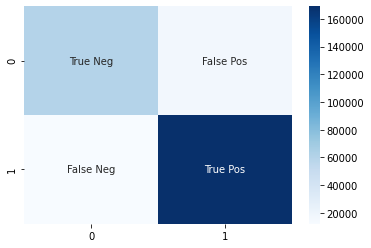

In [230]:
# 시각화 
# !pip install seaborn
import seaborn as sns
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
confusion = confusion_matrix(y_target, pred)
sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')

## 2) 절로 나누지 않고 그대로 학습
 나중에 이 classifier를 절 학습시킬 때 쓰기.
 
 데이터프레임은 7.에서 가져오기

In [11]:
# !pip install transformers

  Using cached transformers-4.9.2-py3-none-any.whl (2.6 MB)
  Using cached huggingface_hub-0.0.12-py3-none-any.whl (37 kB)
  Using cached tokenizers-0.10.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (3.3 MB)
  Using cached sacremoses-0.0.45-py3-none-any.whl (895 kB)
  Using cached filelock-3.0.12-py3-none-any.whl (7.6 kB)
  Using cached PyYAML-5.4.1-cp38-cp38-manylinux1_x86_64.whl (662 kB)
  Using cached typing_extensions-3.10.0.0-py3-none-any.whl (26 kB)


In [4]:
import os
import re
import numpy as np
from tqdm import tqdm

import tensorflow as tf
import transformers

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
# !pip install matplotlib
import matplotlib.pyplot as plt

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

### 전처리

In [265]:
# for uncased 
def clean_text(sent):
  sent = str(sent)
  sent_lower = sent.lower() # lower case
  # sent_clean = re.sub("[^a-z]"," ", sent_lower) # re.sub(감지 할 정규표현식, 대체할 문자, input 텍스트) #only english
  # 지워지고 띄어쓰기가 3개씩 되어있는것도 있는데 ㄱㅊ하겠지? space로 대체 안하면 다 붙음
  # .을 지웠더니 tokenizing에 문제가 생길지? 확인. --> 앵무새책에서는 신경안씀.
  #stop words removal 은 제외. stop = stopwords.words('english')
  return sent_lower
# contents
review['clean_review'] = review['contents'].apply(lambda row: clean_text(row))
review['clean_review']

#header for uncased
review['clean_header'] = review['header'].apply(lambda row: clean_text(row))
review['clean_header']




0               actually quite funny without chris tucker\n
1                                  some good belly laughs\n
2                                      i loved that movie\n
3          worst of the trilogy but still pretty funny a...
4                      will there be another next time???\n
                                ...                        
178071                                          the clash\n
178072     tiresome throwback to the 80's, we've all mov...
178073     an intimate slice of three palestinian person...
178074                             very creepy journey!!!\n
178075     study of the genesis of a serial psychotic ki...
Name: clean_header, Length: 178076, dtype: object

### 모델 훈련

In [266]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [268]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE =32#32는 너무 적소. 더 크게 조정하기.
NUM_EPOCHS = 2
VALID_SPLIT = 0.2
MAX_LEN = 128
DATA_IN_PATH = 'data_in/ENG'
DATA_OUT_PATH = "data_out/ENG"

In [269]:
# !pip install 
bert_model = "bert-base-uncased"
# bert_model = "bert-base-cased"
# bert_model = 'bert-base-multilingual-cased'
tokenizer = transformers.BertTokenizer.from_pretrained(bert_model, cache_dir='bert_ckpt', do_lower_case=False) #bert-base-cased도 가능.
# https://huggingface.co/transformers/pretrained_models.html 에 large 도 등재.

In [270]:
# testing tokenizer
test_sentence = "I love this movie a lot. Thanks to  mr  campbell"

encode = tokenizer.encode(test_sentence)
token_print = [tokenizer.decode(token) for token in encode]

print(encode)
print(token_print)

[101, 100, 2293, 2023, 3185, 1037, 2843, 1012, 100, 2000, 2720, 6063, 102]
['[ C L S ]', '[ U N K ]', 'l o v e', 't h i s', 'm o v i e', 'a', 'l o t', '.', '[ U N K ]', 't o', 'm r', 'c a m p b e l l', '[ S E P ]']


In [271]:
eng_encode = tokenizer.encode("Hello world")
eng_decode = tokenizer.decode(eng_encode)


print(eng_encode)
# [101, 31178, 11356, 102]
print(eng_decode)
# [CLS] Hello world [SEP]

[101, 100, 2088, 102]
[CLS] [UNK] world [SEP]


In [272]:
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

In [273]:
# Use Train data only for fine-tuning
train_data = review[review['train'] == 1]# 실제 코드
# train_data = review[review['train'] == 1][:1000]# for test

input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in tqdm(zip(train_data["clean_review"], train_data["sentiment"]), total=len(train_data)): #  ,uncased 용
# for train_sent, train_label in tqdm(zip(train_data["contents"], train_data["sentiment"]), total=len(train_data)): # 하면안됨 이 df는 sentence용
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_movie_input_ids = np.array(input_ids, dtype=int)
train_movie_attention_masks = np.array(attention_masks, dtype=int)
train_movie_type_ids = np.array(token_type_ids, dtype=int)
train_movie_inputs = (train_movie_input_ids, train_movie_attention_masks, train_movie_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("# sents: {}, # labels: {}".format(len(train_movie_input_ids), len(train_data_labels)))

  0%|                                                | 0/142670 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/ibis/anaconda3/envs/py38tf2/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.war

# sents: 142670, # labels: 142670


In [274]:
input_id = train_movie_input_ids[200]
attention_mask = train_movie_attention_masks[200]
token_type_id = train_movie_type_ids[200]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[  101  1045  2001 26927 14762 24225  2094  2000  2156  1996  6765  1997
  2023  2143  1012  2009  2038  4382  1010  8251  1010  1998  2155 11084
  1012  1045  3811 16755  2009  2005  2402  1998  2214 11455  1012  1045
  2052  2293  2000  3325  1996  3110  1997  1037  1000  4586  2154  1000
  1010  2320  2153  1012 17562  1010  2000  1996  2472  1010  3459  1010
  1998  3626   999   102     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [275]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = transformers.TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)
        return logits

cls_model = TFBertClassifier(model_name=bert_model,
                                  dir_path='bert_ckpt',
                                  num_class=2)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [276]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [5]:

multiworker_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CollectiveCommunication.AUTO


2021-08-24 13:50:16.059960: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-08-24 13:50:16.105380: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-08-24 13:50:16.105406: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ibis-All-Series-Invalid-entry-length-16-Fixed-up-to-11): /proc/driver/nvidia/version does not exist
2021-08-24 13:50:16.106552: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-08-24 13:50:16.115678: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3598265000 Hz
2021-08-24 13:50:16.116464: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f10c8000b60 initialized for platform Host (this does not guarantee th

In [278]:
# model_name = "tf2_bert_imdb_trained"
model_name ="tf2_imdb_"+bert_model+'_maxlen'+str(MAX_LEN)+"_batch"+str(BATCH_SIZE)#+"forheader"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_movie_inputs, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch

print(history.history)
#밑에 나타난 숫자는 그냥 batch에 따라 바뀐 숫자..

data_out/ENG/tf2_imdb_bert-base-uncased_maxlen128_batch32 -- Folder already exists 

Epoch 1/2
3567/3567 [==============================] - ETA: 0s - loss: 0.2048 - accuracy: 0.9194WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).

Epoch 00001: val_accuracy improved from -inf to 0.93506, saving model to data_out/ENG/tf2_imdb_bert-base-uncased_maxlen128_batch32/weights.h5
3567/3567 [==============================] - 1842s 516ms/step - loss: 0.2048 - accuracy: 0.9194 - val_loss: 0.1741 - val_accuracy: 0.9351
Epoch 2/2
3567/3567 [==============================] - ETA: 0s - loss: 0.1211 - accuracy: 0.9554
Epoch 00002: val_accuracy did not improve from 0.93506
3567/3567 [==============================] - 1851s 519ms/step - loss: 0.1211 - accuracy: 0.9554 - val_loss: 0.1945 - val_acc

#### test set 처리
이건.. GRU 등과의 비교를 위함임.

In [279]:
# 모델 weight 불러오는 법. (되나 확인)
bert_finetuned_path = 'data_out/ENG/'+model_name +'/weights.h5'
cls_model.load_weights(bert_finetuned_path)


In [280]:
test_data = review[review['train'] == 0] # 테스트 할당된 헤더로만 평가
test_data

,index,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,3_weeks_later,4_weeks_later,in_n_weeks,Movie_code,sentiment,id,train,clean_review,clean_header
180,180,Stressed out\n,2006-02-06,"No wonder Charlie, the man at the center of th...",0.7,['28 out of 33'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,180,0,"no wonder charlie, the man at the center of th...",stressed out\n
181,181,Brilliant but poor marketing...\n,2004-05-02,"This gem hit box offices in 2000, though there...",1.0,['32 out of 41'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,181,0,"this gem hit box offices in 2000, though there...",brilliant but poor marketing...\n
182,182,great sublime satire...\n,2001-02-21,what is wrong with this film? absolutely nothi...,0.7,['25 out of 34'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,182,0,what is wrong with this film? absolutely nothi...,great sublime satire...\n
183,183,And You Thought You Had It Tough?\n,2002-04-11,"Stress. It comes in many shapes and sizes, to ...",0.8,['17 out of 25'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,183,0,"stress. it comes in many shapes and sizes, to ...",and you thought you had it tough?\n
184,184,"Within the great adversities of life, this fl...",2006-08-05,"Gun Shy is apt title! This underrated comedy, ...",0.8,['17 out of 26'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,184,0,"gun shy is apt title! this underrated comedy, ...","within the great adversities of life, this fl..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177859,177859,One of the worst films I've ever watched\n,2020-10-31,The movie had a good cast but was absolutely a...,0.1,['1 out of 1'],2017-12-22,2017-12-29,2018-01-05,2018-01-12,2018-01-19,after 4 weeks,1966359,0,177859,0,the movie had a good cast but was absolutely a...,one of the worst films i've ever watched\n
177860,177860,Enjoyable\n,2018-04-05,Father figures isn't ground breaking but enjoy...,0.7,['1 out of 1'],2017-12-22,2017-12-29,2018-01-05,2018-01-12,2018-01-19,after 4 weeks,1966359,1,177860,0,father figures isn't ground breaking but enjoy...,enjoyable\n
177861,177861,"Boring, Not funny and Vulgar. The actors shou...",2018-01-02,"I agree with another poster that said ""don't w...",0.2,['13 out of 40'],2017-12-22,2017-12-29,2018-01-05,2018-01-12,2018-01-19,2,1966359,0,177861,0,"i agree with another poster that said ""don't w...","boring, not funny and vulgar. the actors shou..."
178074,178074,Very Creepy Journey!!!\n,2020-03-21,This was one of those movies very well done. I...,0.8,['0 out of 1'],2017-09-29,2017-10-06,2017-10-13,2017-10-20,2017-10-27,after 4 weeks,3630918,1,178074,0,this was one of those movies very well done. i...,very creepy journey!!!\n


In [281]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

# for test_sent, test_label in tqdm(zip(test_data["clean_header"], test_data["sentiment"])): # for header testing (uncased)
# for test_sent, test_label in tqdm(zip(test_data["header"], test_data["sentiment"])): # for header testing(cased)
# for test_sent, test_label in tqdm(zip(test_data["contents"], test_data["sentiment"])): # for contents testing(cased) 
for test_sent, test_label in tqdm(zip(test_data["clean_review"], test_data["sentiment"])): # for contents testing(uncased)
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_movie_input_ids = np.array(input_ids, dtype=int)
test_movie_attention_masks = np.array(attention_masks, dtype=int)
test_movie_type_ids = np.array(token_type_ids, dtype=int)
test_movie_inputs = (test_movie_input_ids, test_movie_attention_masks, test_movie_type_ids)

test_data_labels = np.asarray(test_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(test_movie_input_ids), len(test_data_labels)))

0it [00:00, ?it/s]/home/ibis/anaconda3/envs/py38tf2/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
35406it [01:33, 377.45it/s]


num sents, labels 35406, 35406


In [282]:
results = cls_model.evaluate(test_movie_inputs, test_data_labels, batch_size=1024)
print("test loss, test acc: ", results)

35/35 [==============================] - 147s 4s/step - loss: 0.1721 - accuracy: 0.9361
test loss, test acc:  [0.17210660874843597, 0.9360842704772949]


In [283]:
pred_result = cls_model.predict(test_movie_inputs)
pred = pd.DataFrame(pred_result,columns = ['neg','pos'])

pred['posneg'] = pred['neg'] < pred['pos']
pred['posneg'] = pred['posneg'].apply(lambda x: int(x))
pred

,neg,pos,posneg
0,1.086544,-1.573509,0
1,-3.371792,3.081789,1
2,-0.669288,1.204257,1
3,-2.950360,2.858262,1
4,-4.355113,3.396767,1
...,...,...,...
35401,4.171365,-3.720494,0
35402,-3.783281,3.175611,1
35403,3.545498,-3.124086,0
35404,-4.467367,3.446396,1


In [284]:
test_data.reset_index(drop = True, inplace = True)
test_data

,index,header,date,contents,star,helpful,released_date,1_week_later,2_weeks_later,3_weeks_later,4_weeks_later,in_n_weeks,Movie_code,sentiment,id,train,clean_review,clean_header
0,180,Stressed out\n,2006-02-06,"No wonder Charlie, the man at the center of th...",0.7,['28 out of 33'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,180,0,"no wonder charlie, the man at the center of th...",stressed out\n
1,181,Brilliant but poor marketing...\n,2004-05-02,"This gem hit box offices in 2000, though there...",1.0,['32 out of 41'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,181,0,"this gem hit box offices in 2000, though there...",brilliant but poor marketing...\n
2,182,great sublime satire...\n,2001-02-21,what is wrong with this film? absolutely nothi...,0.7,['25 out of 34'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,182,0,what is wrong with this film? absolutely nothi...,great sublime satire...\n
3,183,And You Thought You Had It Tough?\n,2002-04-11,"Stress. It comes in many shapes and sizes, to ...",0.8,['17 out of 25'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,183,0,"stress. it comes in many shapes and sizes, to ...",and you thought you had it tough?\n
4,184,"Within the great adversities of life, this fl...",2006-08-05,"Gun Shy is apt title! This underrated comedy, ...",0.8,['17 out of 26'],2000-02-04,2000-02-11,2000-02-18,2000-02-25,2000-03-03,after 4 weeks,0171356,1,184,0,"gun shy is apt title! this underrated comedy, ...","within the great adversities of life, this fl..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35401,177859,One of the worst films I've ever watched\n,2020-10-31,The movie had a good cast but was absolutely a...,0.1,['1 out of 1'],2017-12-22,2017-12-29,2018-01-05,2018-01-12,2018-01-19,after 4 weeks,1966359,0,177859,0,the movie had a good cast but was absolutely a...,one of the worst films i've ever watched\n
35402,177860,Enjoyable\n,2018-04-05,Father figures isn't ground breaking but enjoy...,0.7,['1 out of 1'],2017-12-22,2017-12-29,2018-01-05,2018-01-12,2018-01-19,after 4 weeks,1966359,1,177860,0,father figures isn't ground breaking but enjoy...,enjoyable\n
35403,177861,"Boring, Not funny and Vulgar. The actors shou...",2018-01-02,"I agree with another poster that said ""don't w...",0.2,['13 out of 40'],2017-12-22,2017-12-29,2018-01-05,2018-01-12,2018-01-19,2,1966359,0,177861,0,"i agree with another poster that said ""don't w...","boring, not funny and vulgar. the actors shou..."
35404,178074,Very Creepy Journey!!!\n,2020-03-21,This was one of those movies very well done. I...,0.8,['0 out of 1'],2017-09-29,2017-10-06,2017-10-13,2017-10-20,2017-10-27,after 4 weeks,3630918,1,178074,0,this was one of those movies very well done. i...,very creepy journey!!!\n


In [285]:
# pred 값(posneg)과 test_dat 합치기
test_data = pd.concat([test_data,pred['posneg']],axis = 1)
test_data['posneg']

0        0
1        1
2        1
3        1
4        1
        ..
35401    0
35402    1
35403    0
35404    1
35405    1
Name: posneg, Length: 35406, dtype: int64

In [286]:
#null 제거
test_data = test_data[~test_data['posneg'].isna()]


In [287]:
# 타입 통일. int로.
test_data['sentiment'] = test_data['sentiment'].astype('int')
test_data['posneg'] = test_data['posneg'].astype('int')

In [288]:
# !pip install sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, plot_confusion_matrix
from sklearn.metrics import recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test=None, pred=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [289]:
# test에 대한 평가
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, plot_confusion_matrix
from sklearn.metrics import recall_score, f1_score, roc_auc_score


y_target = test_data['sentiment'].values
pred = test_data['posneg'].values



get_clf_eval(y_target, pred)

# confusion = confusion_matrix(y_target, pred)
# print(confusion)
# print("정확도:", np.round(accuracy_score(y_target , pred),4))
# print("정밀도:", np.round(precision_score(y_target , pred),4))
# print("재현율:", np.round(recall_score(y_target, pred),4))

오차 행렬
[[ 9413  1484]
 [  779 23730]]
정확도: 0.9361, 정밀도: 0.9411, 재현율: 0.9682,    F1: 0.9545, AUC:0.9160


<AxesSubplot:>

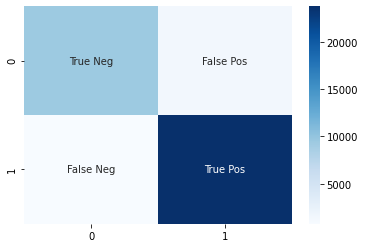

In [290]:
# 시각화 
# !pip install seaborn
import seaborn as sns
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
confusion = confusion_matrix(y_target, pred)
sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')

## 3) 단문대신 header를 훈련 
header 는 길이가 짧으니까.

In [ ]:
review_len = review['header'].apply(lambda review: len(review))
review_len

In [ ]:
review_len.mean() # 35.8
review_len.median() # 31
# 단문으로 학습하기 적절하다고 생각됨. 

31.0

# End.

# Predict 값 간의 CORR 확인

In [ ]:
sw

In [ ]:
vader.reset_index(inplace = True)
vader

In [ ]:
cnn

In [ ]:
gru['gru'] = gru['pred']
gru

In [ ]:
test_preds = pd.concat([vader,cnn,gru,sw],axis = 1)
test_preds

In [ ]:
sw.reset_index(inplace = True)
test_preds = pd.concat([vader,cnn,gru,sw],axis = 1)
test_preds = test_preds[['senti','vader_preds','cnn','gru','in_n_weeks','Movie_code']]
with open('test_preds','wb') as fw:
  pickle.dump(test_preds,fw)


In [ ]:
with open('test_preds','rb') as fr:
  t = pickle.load(fr)
t

,senti,vader_preds,cnn,gru,in_n_weeks,in_n_weeks,in_n_weeks,in_n_weeks,Movie_code,Movie_code,Movie_code,Movie_code
0,1.0,1,1,1,after 4 weeks,after 4 weeks,after 4 weeks,after 4 weeks,0171356,0171356,171356,0171356
1,1.0,1,1,1,after 4 weeks,after 4 weeks,after 4 weeks,after 4 weeks,0171356,0171356,171356,0171356
2,1.0,1,1,1,after 4 weeks,after 4 weeks,after 4 weeks,after 4 weeks,0171356,0171356,171356,0171356
3,1.0,1,1,1,after 4 weeks,after 4 weeks,after 4 weeks,after 4 weeks,0171356,0171356,171356,0171356
4,1.0,1,1,1,after 4 weeks,after 4 weeks,after 4 weeks,after 4 weeks,0171356,0171356,171356,0171356
...,...,...,...,...,...,...,...,...,...,...,...,...
35403,0.0,0,0,0,after 4 weeks,after 4 weeks,after 4 weeks,after 4 weeks,1966359,1966359,1966359,1966359
35404,1.0,1,1,1,after 4 weeks,after 4 weeks,after 4 weeks,after 4 weeks,1966359,1966359,1966359,1966359
35405,0.0,0,0,0,2,2,2,2,1966359,1966359,1966359,1966359
35406,1.0,1,1,1,after 4 weeks,after 4 weeks,after 4 weeks,after 4 weeks,3630918,3630918,3630918,3630918


In [ ]:
t = t[['senti',	'vader_preds',	'cnn',	'gru']]
t = t.fillna(1) #senti 에 nan 두개
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35408 entries, 0 to 35407
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   senti        35408 non-null  float64
 1   vader_preds  35408 non-null  int64  
 2   cnn          35408 non-null  int64  
 3   gru          35408 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 1.1 MB


In [ ]:
#정답도 추가
ans = review[['sentiment']]
ans.reset_index(drop = True,inplace = True)
t = pd.concat([ans,t],axis =1)

t['answer'] = t['sentiment']
t = t.drop('sentiment',axis = 1)

In [ ]:
t = t.astype('int')
t.corr(method = 'pearson')
# 역시 성능좋은 gru와 cnn이 가장 굳.. 

,senti,vader_preds,cnn,gru,answer,lstm
senti,1.000000,0.379379,0.318947,0.314890,0.314747,NaN
vader_preds,0.379379,1.000000,0.436139,0.445902,0.440175,NaN
cnn,0.318947,0.436139,1.000000,0.826915,0.791651,NaN
gru,0.314890,0.445902,0.826915,1.000000,0.850831,NaN
answer,0.314747,0.440175,0.791651,0.850831,1.000000,NaN
lstm,NaN,NaN,NaN,NaN,NaN,NaN
